In [1]:
!pip install seaborn --upgrade

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import random
import pickle

from matplotlib.colors import ListedColormap
from random import choices
from scipy import stats
from statsmodels.miscmodels.ordinal_model import OrderedModel
from tqdm.notebook import tqdm

In [5]:
import warnings
import copy
warnings.filterwarnings(action="ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action="ignore", category=pd.errors.PerformanceWarning)

In [6]:
from jupyter_utils import style, mean_std, display_test, display_group_test, scatter_annotate, show_corrtest_mask_corr
from ortogonolize_utils import draw_scatter, draw_corrected_scatter
from ortogonolize_utils import compute_coefficient, compute_ortogonolized_coefficient, compute_ortogonolized_logit

In [7]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/'

## merge data with psychosocial data

In [8]:
df = pd.read_csv(PATH +'rus_merged_psychosocial_data.csv', index_col=0)
df = df[df.index.notnull()]
df.rename(columns={'dep.severity-1': 'dep.severity',
                  'HDRS-17.score-1': 'HDRS-17',
                   'panss-1-td': 'panss_td',
                   'panss-1-total': 'panss_total', 
                   'panss-n-1-total': 'panss_neg', 
                   'panss-o-1-total': 'panss_o',
                   'panss-p-1-total': 'panss_pos', 
                   'sans-1-total': 'sans',
                   'saps-ftd-1-total': 'saps_ftd', 
                   'sops-1-total': 'sops_total', 
                   'sops-c-total': 'sops_c',
                   'sops-d-total': 'sops_d', 
                   'sops-n-total': 'sops_n', 
                   'sops-p-total': 'sops_p'
                  }, inplace=True)
df['index'] = df.index
df.drop_duplicates(inplace=True, subset='index')
df.drop(columns=['index'], inplace=True)

In [9]:
len(df)

176

In [10]:
res_df = pd.read_csv(PATH + 'processed_values/ru_both.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [11]:
len(res_df)

183

In [12]:
dfi = [i.replace('-', '').replace('S', 'PD1') for i in df.index]
df.index = dfi
# res_df.index = [i.replace('S', 'PD1') for i in res_df.index]
rdfi = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]

missing_psy = set(rdfi).difference(set(dfi))
missing_psy

{'PN005', 'PN006', 'PN012', 'PN014', 'PN019', 'PN238', 'PN327'}

In [13]:
missing_psy = [i for i in res_df.index if i.split('_')[0] in missing_psy]
res_df.drop(missing_psy, inplace=True)

In [14]:
len(res_df)

176

In [15]:
missing_text = set(dfi).difference(set(rdfi))
assert not missing_text

In [16]:
non_start_timepoint = [i for i in res_df.index if i.split('_')[-1] != '1']
res_df.drop(non_start_timepoint, inplace=True)

In [17]:
# res_df.loc['PD101_1'].dropna()

In [18]:
rdfi_filtered = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]
res_df.index = rdfi_filtered

## features of raw texts

In [19]:
raw = pd.read_csv(PATH+'rus_transcript_lex_by_task_with_dots.tsv', sep='\t', index_col=0)

In [20]:
ids_to_drop = [i for i in raw.index if i.split('_')[0] not in res_df.index]

In [21]:
raw.drop(index=ids_to_drop, inplace=True)

In [22]:
raw.index = [i.split('_')[0] for i in raw.index]

In [23]:
raw.isna().sum(axis=0).sum()

1060

<AxesSubplot: >

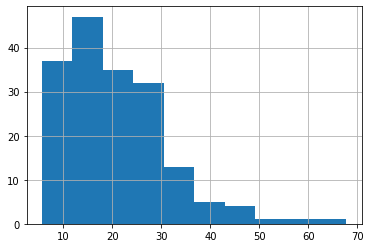

In [24]:
raw.applymap(lambda x: len(x.split('.')) if not pd.isna(x) else np.nan).mean(axis=1).hist()

## look at tasks

In [25]:
task_available = raw.applymap(lambda x: 1 if not pd.isna(x) else x)

In [26]:
len(task_available)

176

In [27]:
task_available['diagnosis.type'] = df['diagnosis.type']

In [28]:
task_available.count()

adventure         99
bench             28
chair             75
party             35
present           81
sportsman         96
table             30
trip              40
winterday         40
diagnosis.type    49
dtype: int64

In [29]:
task_available.groupby('diagnosis.type').count()

,adventure,bench,chair,party,present,sportsman,table,trip,winterday
diagnosis.type,,,,,,,,,
dep,14,0,14,0,13,14,0,0,0
sz,30,0,17,0,21,28,0,1,0


In [30]:
task_available.groupby('diagnosis.type').count()[task_available.groupby('diagnosis.type').count() > 0].dropna(axis=1)

,adventure,chair,present,sportsman
diagnosis.type,,,,
dep,14,14,13,14
sz,30,17,21,28


In [31]:
def drop_person(row):
    for task in ('adventure', 'chair','present','sportsman'):
        if not pd.isna(row[task]):
            return False
    return True

In [32]:
ids_with_at_least_one_task = task_available[~task_available.apply(drop_person, axis=1)].index

In [33]:
df = df.loc[ids_with_at_least_one_task]

In [34]:
TASKS = ['adventure', 'chair','present','sportsman']

In [35]:
res_df = res_df.loc[ids_with_at_least_one_task, TASKS]

In [36]:
res_df[[(task, 'syntactic', 'mean_sent_len') for task in TASKS]].mean()

TASK                               
adventure  syntactic  mean_sent_len    7.165963
chair      syntactic  mean_sent_len    8.668295
present    syntactic  mean_sent_len    9.724067
sportsman  syntactic  mean_sent_len    7.770671
dtype: float64

In [37]:
res_df[[(task, 'syntactic', 'n_sents') for task in TASKS]].mean()

TASK                         
adventure  syntactic  n_sents    19.393939
chair      syntactic  n_sents    18.506667
present    syntactic  n_sents    14.000000
sportsman  syntactic  n_sents    17.635417
dtype: float64

In [38]:
res_df[[(task, 'lexical', 'n_words') for task in TASKS]].mean()

TASK                       
adventure  lexical  n_words    137.979798
chair      lexical  n_words    159.866667
present    lexical  n_words    127.802469
sportsman  lexical  n_words    131.322917
dtype: float64

In [39]:
def task_data(df, task, keep_target=True, fill_synt=True):
    subset = df[task].dropna(axis=0, how='all')
    if fill_synt:
        subset['syntactic'] = subset['syntactic'].fillna(0.0)
    if keep_target:
        subset = pd.concat([subset, df['target'].loc[subset.index]], axis=1)
    return subset

In [40]:
def aplly_to_all_tasks(df, f, tasks=TASKS, to_df=True, *args, **kwargs):
    res = {}
    for task in tasks:
        data = task_data(df, task)
        res[task] = f(data, *args, **kwargs)
    if to_df:
        if all(isinstance(v, pd.Series) for v in res.values()):
            return pd.DataFrame(res)
        elif all(isinstance(v, pd.DataFrame) for v in res.values()):
            return pd.concat(list(res.values()), keys=list(res.keys()), names=['task'], axis=1)
        else:
            return res
    return res

## psychosocial statistics

In [41]:
def fill_diagnosis_type(row):
    dt = row['diagnosis.type']
    if not pd.isna(dt):
        return dt
    else:
        if not pd.isna(row['td.severity']):
            return 'control_psy'
        else:
            return 'control'

In [42]:
df['diagnosis.type'] = df.apply(fill_diagnosis_type, axis=1)

In [43]:
sz = df[df['diagnosis.type'] == 'sz']
dep = df[df['diagnosis.type'] == 'dep']
control = df[df['diagnosis.group'] == 'control']
control_psy = df[df['diagnosis.type'] == 'control_psy']

In [44]:
df.columns

Index(['age', 'dep.scale', 'dep.severity', 'group.code', 'diagnosis.group',
       'diagnosis.type', 'diagnosis_code', 'diagnosis_eng', 'diagnosis_rus',
       'education.level.code', 'education.level.eng', 'education.years',
       'exacerbation', 'HDRS-17', 'longitudinal', 'panss_td', 'panss_total',
       'panss_neg', 'panss_o', 'panss_pos', 'rehospitalization', 'sans',
       'saps_ftd', 'sex', 'sops_total', 'sops_c', 'sops_d', 'sops_n', 'sops_p',
       'td.scales', 'td.severity'],
      dtype='object')

In [45]:
df['diagnosis.group'].value_counts()

control    102
patient     49
Name: diagnosis.group, dtype: int64

In [46]:
df['diagnosis.type'].value_counts()

control        72
sz             31
control_psy    30
dep            18
Name: diagnosis.type, dtype: int64

In [47]:
df['dep.scale'].value_counts()

HDRS    51
QIDS    28
Name: dep.scale, dtype: int64

In [48]:
df['td.scales'].value_counts()

PANSS       28
SCL-90-R    28
SAPS        21
Name: td.scales, dtype: int64

In [49]:
df.groupby('diagnosis.type')[['diagnosis_code', 'diagnosis_eng']].value_counts()

diagnosis.type  diagnosis_code  diagnosis_eng                                    
dep             F31             bipolar.affective.disorder                            6
                F60.31          borderline.personality.disorder                       3
                F31.4           bipolar.affective.disorder.severe                     2
                F31.5           bipolar.affective.disorder.severe.psychotic           2
                F33             recurrent.depressive.disorder                         2
                F32.1           depressive.episode.moderate                           1
                F33.3           recurrent.depressive.disorder.severe.psychotic        1
                F60             personality.disorder                                  1
sz              F20             schizophrenia                                        20
                F25             schizoaffective.disorder                              8
                F21             schizo

### select target cols

In [50]:
target_cols = ['sex', 'age', 'education.years', 
               'diagnosis.group', 'diagnosis.type',
               'dep.severity', 'td.severity']

In [51]:
# panss_cols = [col for col in df.columns if col.startswith('panss')]
panss_cols = ['panss_td', 'panss_total', 'panss_neg', 'panss_pos', 'panss_o']
sans_cols = [col for col in df.columns if col.startswith('sans')]
saps_cols = [col for col in df.columns if col.startswith('saps')]
sops_cols = [col for col in df.columns if col.startswith('sops')]

In [52]:
numeric_target = ['education.years','dep.severity','td.severity'] + panss_cols

In [53]:
# sz.count()[sz.count() > 0]

In [54]:
# dep.count()[dep.count() > 0]

In [55]:
sz['sex'].value_counts()

female    25
male       6
Name: sex, dtype: int64

In [56]:
mean_std(sz, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,27.13 (7.14),13.32 (2.41),0.58 (0.85),0.84 (0.73),10.03 (3.74),69.79 (16.13),22.93 (8.59),15.9 (4.92),30.97 (8.42)


In [57]:
mean_std(sz, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
sex,,,,,,,,,
female,27.8 (7.53),13.56 (2.48),0.72 (0.89),0.8 (0.76),9.43 (3.62),69.13 (15.38),22.52 (7.79),15.3 (4.91),31.3 (9.08)
male,24.33 (4.72),12.33 (1.97),0.0 (0.0),1.0 (0.63),12.33 (3.56),72.33 (20.16),24.5 (11.93),18.17 (4.67),29.67 (5.65)


In [58]:
r = mean_std(sz, ['dep.severity', 'td.severity'] + panss_cols)
r.loc['max'] = pd.Series([4, 4, 28, 210, 49, 49, 112], index=r.columns)
r.loc['min'] = pd.Series([0, 0, 2, 30, 7, 7, 16], index=r.columns)
r.loc['share'] = r.loc['value'].apply(lambda x: float(x.split(' ')[0])) / r.loc['max'] 

In [59]:
r

,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,0.58 (0.85),0.84 (0.73),10.03 (3.74),69.79 (16.13),22.93 (8.59),15.9 (4.92),30.97 (8.42)
max,4,4,28,210,49,49,112
min,0,0,2,30,7,7,16
share,0.145,0.21,0.358214,0.332333,0.467959,0.32449,0.276518


In [60]:
dep['sex'].value_counts()

female    18
Name: sex, dtype: int64

In [61]:
mean_std(dep, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,20.89 (3.71),12.67 (1.94),0.56 (0.62),0.06 (0.24),4.42 (0.9),37.92 (5.89),8.31 (1.97),8.46 (1.94),21.15 (3.58)


In [62]:
dep['panss_o'].count()

13

In [63]:
control['sex'].value_counts()

female    75
male      27
Name: sex, dtype: int64

In [64]:
mean_std(control, target_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity
value,39.75 (19.15),15.74 (2.57),0.0 (0.0),0.0 (0.0)


In [65]:
mean_std(control, target_cols, 'sex')

,age,education.years,dep.severity,td.severity
sex,,,,
female,38.25 (18.85),15.39 (2.39),0.0 (0.0),0.0 (0.0)
male,43.93 (19.73),16.7 (2.83),0.0 (0.0),0.0 (0.0)


In [66]:
control_psy['sex'].value_counts()

female    26
male       4
Name: sex, dtype: int64

In [67]:
mean_std(control_psy, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,25.0 (7.4),15.43 (2.13),0.0 (0.0),0.0 (0.0),4.36 (1.0),30.77 (1.54),7.23 (0.53),7.23 (0.61),16.32 (0.95)


In [68]:
mean_std(control_psy, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
sex,,,,,,,,,
female,25.42 (7.8),15.42 (1.7),0.0 (0.0),0.0 (0.0),4.4 (1.05),30.85 (1.6),7.25 (0.55),7.25 (0.64),16.35 (0.99)
male,22.25 (3.3),15.5 (4.43),0.0 (0.0),0.0 (0.0),4.0 (0.0),30.0 (0.0),7.0 (0.0),7.0 (0.0),16.0 (0.0)


In [69]:
control.groupby('sex')['panss_total'].count()

sex
female    20
male       2
Name: panss_total, dtype: int64

In [70]:
# control_psy.count()[control_psy.count() > 0]

In [71]:
# df.dropna(axis=0, thresh=30).iloc[0]

### test for differences

age

In [72]:
stats.ttest_ind(control['age'], sz['age'], nan_policy='omit')

Ttest_indResult(statistic=3.5871243575285408, pvalue=0.00047085918746073396)

In [73]:
stats.ttest_ind(control_psy['age'], sz['age'], nan_policy='omit')

Ttest_indResult(statistic=-1.143255849283786, pvalue=0.2575501479174914)

In [74]:
stats.ttest_ind(control_psy['age'], dep['age'], nan_policy='omit')

Ttest_indResult(statistic=2.1899209175114764, pvalue=0.033638603323606325)

eduaction years

In [75]:
stats.ttest_ind(control['education.years'], sz['education.years'], nan_policy='omit')

Ttest_indResult(statistic=4.653034980872723, pvalue=7.949204742694471e-06)

In [76]:
stats.ttest_ind(control_psy['education.years'], sz['education.years'], nan_policy='omit')

Ttest_indResult(statistic=3.618089157043871, pvalue=0.0006167702505040491)

In [77]:
stats.ttest_ind(control_psy['education.years'], dep['education.years'], nan_policy='omit')

Ttest_indResult(statistic=4.502842757884748, pvalue=4.561269295083997e-05)

sex

In [78]:
a = 0.05

In [79]:
s_t_sex, res_t_sex = display_group_test(control, numeric_target, 'sex', stats.ttest_ind, stat_name='t', alpha=a)
style(res_t_sex)

,t,p,sig,abs_t
education.years,2.321636,0.022302,True,2.321636
dep.severity,nan,nan,False,nan
td.severity,nan,nan,False,nan
panss_td,-0.528886,0.602706,False,0.528886
panss_total,-0.735628,0.470497,False,0.735628
panss_neg,-0.628695,0.536664,False,0.628695
panss_pos,-0.541530,0.594124,False,0.541530
panss_o,-0.490038,0.629439,False,0.490038


In [80]:
s_t_sex, res_t_sex = display_group_test(control_psy, numeric_target, 'sex', stats.ttest_ind, stat_name='t', alpha=a)
style(res_t_sex)

,t,p,sig,abs_t
education.years,0.066128,0.947746,False,0.066128
dep.severity,nan,nan,False,nan
td.severity,nan,nan,False,nan
panss_td,-0.528886,0.602706,False,0.528886
panss_total,-0.735628,0.470497,False,0.735628
panss_neg,-0.628695,0.536664,False,0.628695
panss_pos,-0.541530,0.594124,False,0.541530
panss_o,-0.490038,0.629439,False,0.490038


In [81]:
s_t_sex, res_t_sex = display_group_test(sz, numeric_target, 'sex', stats.ttest_ind, stat_name='t', alpha=a)
style(res_t_sex)

,t,p,sig,abs_t
education.years,-1.122772,0.270744,False,1.122772
dep.severity,-1.954622,0.060329,False,1.954622
td.severity,0.592289,0.558247,False,0.592289
panss_td,1.753714,0.090826,False,1.753714
panss_total,0.426912,0.672829,False,0.426912
panss_neg,0.495589,0.624194,False,0.495589
panss_pos,1.282777,0.210473,False,1.282777
panss_o,-0.418000,0.679253,False,0.418000


### correlation between target variables

In [82]:
# display corr test

In [83]:
x, y = display_test(df, numeric_target, 'age', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
education.years,0.468966,0.0,True,0.468966
panss_neg,0.383708,0.001749,True,0.383708


In [84]:
x, y = display_test(df, numeric_target, 'education.years', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
panss_o,-0.407709,0.000826,True,0.407709
dep.severity,-0.331386,0.002852,True,0.331386


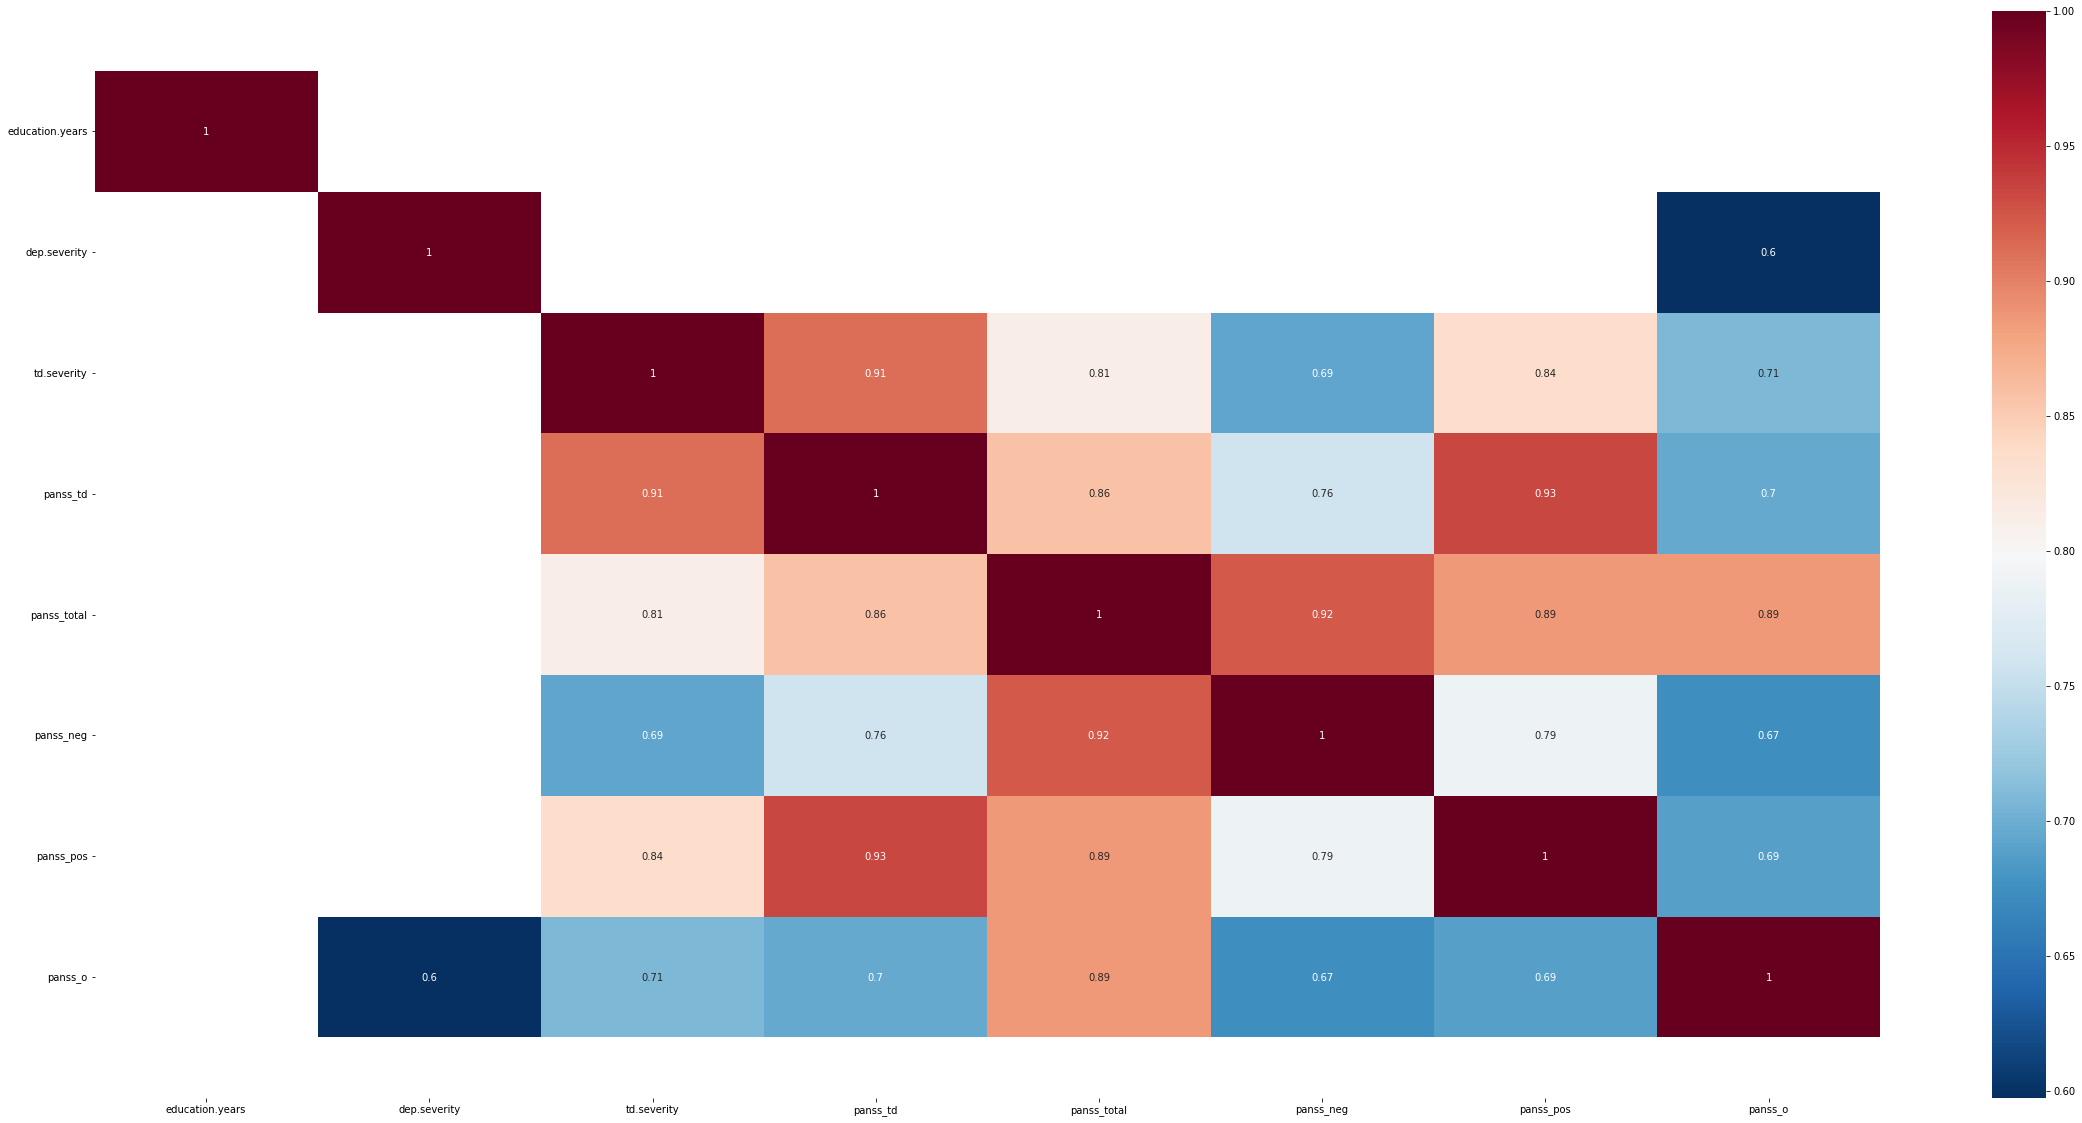

In [85]:
target_corr_res = show_corrtest_mask_corr(df[numeric_target])

## scores

In [86]:
# res_df

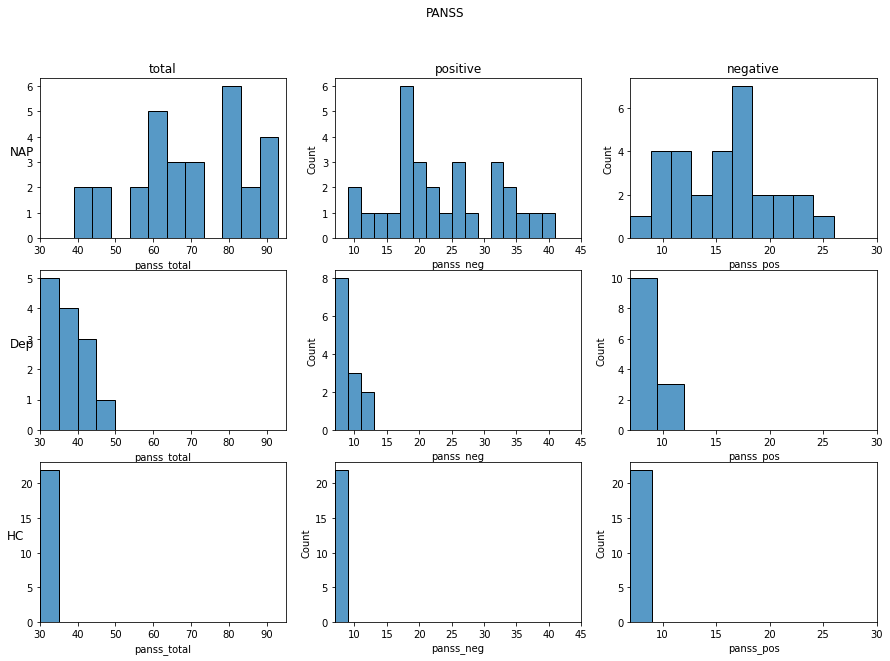

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('PANSS')


sns.histplot(sz['panss_total'], ax=axes[0, 0], binwidth=5)
axes[0, 0].set_xlim(30, 95)
sns.histplot(dep['panss_total'], ax=axes[1, 0], binwidth=5)
axes[1, 0].set_xlim(30, 95)
sns.histplot(control_psy['panss_total'], ax=axes[2, 0], binwidth=5)
axes[2, 0].set_xlim(30, 95)
sns.histplot(sz['panss_neg'], ax=axes[0, 1], binwidth=2)
axes[0, 1].set_xlim(7, 45)
sns.histplot(dep['panss_neg'], ax=axes[1, 1], binwidth=2)
axes[1, 1].set_xlim(7, 45)
sns.histplot(control_psy['panss_neg'], ax=axes[2, 1], binwidth=2)
axes[2, 1].set_xlim(7, 45)
sns.histplot(sz['panss_pos'], ax=axes[0, 2], binwidth=2)
axes[0, 2].set_xlim(7, 30)
sns.histplot(dep['panss_pos'], ax=axes[1, 2], binwidth=2)
axes[1, 2].set_xlim(7, 30)
sns.histplot(control_psy['panss_pos'], ax=axes[2, 2], binwidth=2)
axes[2, 2].set_xlim(7, 30)

for ax, col in zip(axes[0], ('total', 'positive', 'negative')):
    ax.set_title(col)

for ax, row in zip(axes[:,0], ('NAP', 'Dep', 'HC')):
    ax.set_ylabel(row, rotation=0, size='large')

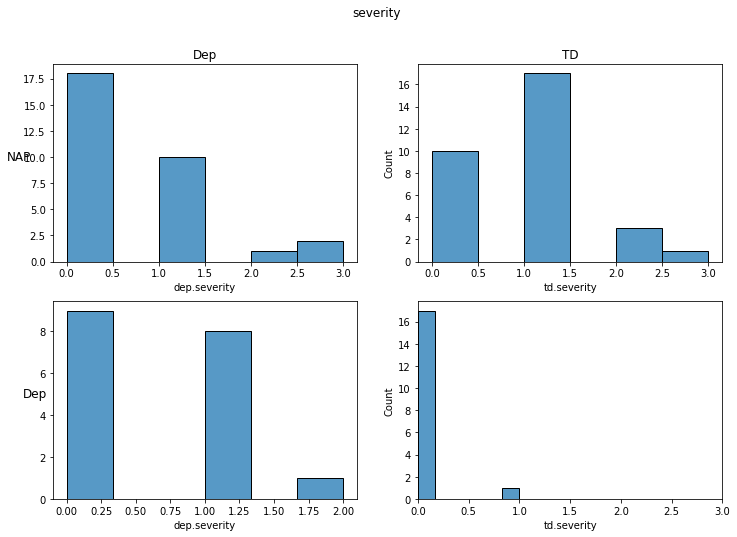

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('severity')


sns.histplot(sz['dep.severity'], ax=axes[0, 0])
sns.histplot(dep['dep.severity'], ax=axes[1, 0])
sns.histplot(sz['td.severity'], ax=axes[0, 1])
sns.histplot(dep['td.severity'], ax=axes[1, 1])
axes[1, 1].set_xlim(0, 3)

for ax, col in zip(axes[0], ('Dep', 'TD')):
    ax.set_title(col)

for ax, row in zip(axes[:,0], ('NAP', 'Dep')):
    ax.set_ylabel(row, rotation=0, size='large')

### merge psychoscial data to scores

In [89]:
merge_df = res_df.copy()
for col in target_cols + panss_cols:
    merge_df[('target', 'target', col)] = df[col]

In [90]:
cols_tasks = res_df['sportsman'].columns
cols_LM = [col for col in res_df['sportsman'] if col[0] == 'LM']
cols_synt = [col for col in res_df['sportsman'] if col[0] == 'syntactic']
cols_lex = [col for col in res_df['sportsman'] if col[0] == 'lexical']
cols_graph = [col for col in res_df['sportsman'] if col[0] == 'graph']

In [91]:
POS_to_use = ('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')
pos = set([x[1] for x in cols_synt if x[1].isupper()])

pos.difference(set(('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')))

{'ADP', 'INTJ', 'NUM', 'PUNCT', 'SPACE', 'X'}

In [92]:
pos_cols_to_drop = [(task, c[0], c[1]) for task in TASKS for c in cols_synt if c[1].isupper() and c[1] not in POS_to_use and (task, c[0], c[1]) in merge_df.columns]

In [93]:
pos_cols_to_drop

[('adventure', 'syntactic', 'ADP'),
 ('adventure', 'syntactic', 'NUM'),
 ('adventure', 'syntactic', 'PUNCT'),
 ('adventure', 'syntactic', 'SPACE'),
 ('adventure', 'syntactic', 'X'),
 ('chair', 'syntactic', 'ADP'),
 ('chair', 'syntactic', 'INTJ'),
 ('chair', 'syntactic', 'NUM'),
 ('chair', 'syntactic', 'PUNCT'),
 ('chair', 'syntactic', 'SPACE'),
 ('present', 'syntactic', 'ADP'),
 ('present', 'syntactic', 'NUM'),
 ('present', 'syntactic', 'PUNCT'),
 ('present', 'syntactic', 'SPACE'),
 ('present', 'syntactic', 'X'),
 ('sportsman', 'syntactic', 'ADP'),
 ('sportsman', 'syntactic', 'INTJ'),
 ('sportsman', 'syntactic', 'NUM'),
 ('sportsman', 'syntactic', 'PUNCT'),
 ('sportsman', 'syntactic', 'SPACE'),
 ('sportsman', 'syntactic', 'X')]

In [94]:
merge_df.drop(columns=pos_cols_to_drop, inplace=True)

In [95]:
merge_df.columns.unique(level='TASK')

Index(['adventure', 'chair', 'present', 'sportsman', 'target'], dtype='object', name='TASK')

In [96]:
cols_synt = [col for col in merge_df['chair'] if col[0] == 'syntactic']
cols_tasks = cols_synt + cols_LM + cols_lex + cols_graph

In [97]:
def corr(df, target):
    return df[~pd.isnull(df[target])].corr()[target]

In [98]:
def corr_thresh(df, target, thresh=0.3, drop_target=True):
    corr_tgt = corr(df, target)
    if drop_target:
        corr_tgt.drop('target', inplace=True)
    return corr_tgt[abs(corr_tgt) >= thresh]

In [99]:
def ttest(df, test_columns, group):
    s_t, res_t = display_group_test(df, test_columns, group, stats.ttest_ind, stat_name='t', alpha=a)
    return res_t[['t', 'p']]

### psychosocial variables vs metrics

In [100]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'age')))

In [101]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'education.years')))

In [102]:
control = merge_df[merge_df[('target', 'target', 'diagnosis.group')] == 'control']

In [103]:
style(aplly_to_all_tasks(control, corr_thresh, target=('target', 'age'), thresh=0.4))

In [104]:
style(aplly_to_all_tasks(control, corr_thresh, target=('target', 'education.years'), thresh=0.4))

### psychiatric variables vs metrics

In [105]:
def thresh_any_task(df, col='p', tasks=TASKS, thresh=0.05):
    return df[df.apply(lambda row: any([row[task][col] < thresh for task in tasks]), axis=1)]

In [106]:
res = aplly_to_all_tasks(merge_df, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.group'))
style(thresh_any_task(res, thresh=0.01))

In [107]:
def ttest_select(df, test_two_groups, colname, cols_tasks=cols_tasks):
    groups = df[df[('target', colname)].isin(test_two_groups)]
    s_t, res_t = display_group_test(groups, cols_tasks, ('target', colname), test=stats.ttest_ind, stat_name='t', alpha=a)
    return res_t['t']

In [108]:
chair = task_data(merge_df, 'chair')

In [109]:
ttest_select(chair, ('sz', 'control_psy'), 'diagnosis.type')

(syntactic, ADJ)              0.490088
(syntactic, ADV)             -0.294076
(syntactic, AUX)             -0.475141
(syntactic, CCONJ)             0.96283
(syntactic, DET)             -0.003997
(syntactic, NOUN)             1.159196
(syntactic, PART)            -2.935745
(syntactic, PRON)             0.398696
(syntactic, PROPN)           -1.389632
(syntactic, SCONJ)           -0.307485
(syntactic, VERB)             0.272148
(syntactic, max_sent_len)     2.101802
(syntactic, mean_sent_len)    3.331125
(syntactic, min_sent_len)     0.793557
(syntactic, n_sents)           3.35693
(syntactic, std_sent_len)     0.644918
(LM, m_bert_cgcoh)           -0.431062
(LM, m_bert_gcoh)             0.102419
(LM, m_bert_lcoh)             0.765065
(LM, m_bert_scoh)             0.653857
(LM, m_cgcoh)                 1.051026
(LM, m_gcoh)                  1.321195
(LM, m_lcoh)                  1.510666
(LM, m_raw_cgcoh)             0.077593
(LM, m_raw_gcoh)              1.058816
(LM, m_raw_lcoh)         

In [110]:
test_two_groups = ('sz', 'control_psy')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

In [111]:
test_two_groups = ('sz', 'control')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

In [112]:
test_two_groups = ('dep', 'control_psy')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

In [113]:
test_two_groups = ('dep', 'sz')
groups = merge_df[merge_df[('target', 'target','diagnosis.type')].isin(test_two_groups)]
res = aplly_to_all_tasks(groups, ttest, test_columns=cols_tasks, group=('target', 'diagnosis.type'))
style(thresh_any_task(res, thresh=0.005))

### Corr

In [114]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_total')))

In [115]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_pos')))

In [116]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_neg')))

In [117]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_o')))

## Ordered Model

In [118]:
psy_td = df[~pd.isna(df['td.severity'])]

In [119]:
psy_td['td.severity'] = psy_td.loc[:,'td.severity'].astype(pd.CategoricalDtype(ordered=True))
psy_td = psy_td.loc[psy_td[['td.severity', 'panss_total', 'panss_pos', 'panss_neg']].dropna().index]

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_16597/3739057385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psy_td['td.severity'] = psy_td.loc[:,'td.severity'].astype(pd.CategoricalDtype(ordered=True))


In [120]:
def compute_pseudo_rsquared_ordered(df, target_col, predictor_cols):
    df = df.loc[df[[target_col] + predictor_cols].dropna().index]
    mod_prob = OrderedModel(df[target_col],
                        df[predictor_cols],
                        distr='probit')

    res_prob = mod_prob.fit(method='bfgs', disp=0)
    return res_prob.prsquared

In [121]:
compute_pseudo_rsquared_ordered(psy_td, 'td.severity', ['panss_total', 'panss_pos', 'panss_neg'])

0.6742463723003046

In [122]:
compute_pseudo_rsquared_ordered(psy_td, 'td.severity', ['panss_total', 'panss_pos'])

0.6665934072022907

In [123]:
compute_pseudo_rsquared_ordered(psy_td, 'td.severity', ['panss_total'])

0.5952968595542267

In [124]:
compute_pseudo_rsquared_ordered(psy_td, 'dep.severity', ['panss_neg'])

0.020654112989205275

In [125]:
compute_pseudo_rsquared_ordered(psy_td, 'dep.severity', ['panss_o'])

0.18924309868

In [126]:
compute_pseudo_rsquared_ordered(chair, ('target', 'dep.severity'), [('LM', 'm_cgcoh')])

0.06443780408932076

## Length

In [127]:
tasks_len = aplly_to_all_tasks(merge_df, corr_thresh, target=('syntactic', 'mean_sent_len'), thresh=0.5)
tasks_len.drop(index=[('syntactic', 'mean_sent_len')], inplace=True)
style(tasks_len)

In [128]:
tasks_len = aplly_to_all_tasks(merge_df, corr_thresh, target=('syntactic', 'mean_sent_len'), thresh=0.)
tasks_len.drop(index=[('syntactic', 'mean_sent_len')], inplace=True)

In [129]:
ex_df = pd.DataFrame()
for task in TASKS:
    df_ = pd.DataFrame()
    df_['metric'] = tasks_len[task]
    df_['task'] = task
    df_['index'] = [x[1] for x in df_.index]
    df_['type'] = [x[0] for x in df_.index]
    ex_df = pd.concat([ex_df, df_])

In [130]:
def catplot(data, x, y, hue, col=None, ax=None):
    sns.set_theme(style="whitegrid")

    # Draw a pointplot to show pulse as a function of three categorical factors
    g = sns.catplot(
        data=data, x=x, y=y, hue=hue, col=col,
        capsize=.2,  # errorbar="se",
        kind="point", height=6, aspect=.75, ax=ax)
    g.despine(left=True);

In [131]:
def pointplot(data, x, y, hue, ax=None, use_errorbar=False, **kwargs):
    sns.set_theme(style="whitegrid")
    if not use_errorbar:
        g = sns.pointplot(data=data, x=x, y=y, hue=hue, ax=ax,**kwargs);
    else:
        sns.pointplot(data=data, x=x, y=y, hue=hue, ax=ax, 
                      estimator='median', errorbar=('pi', 50), dodge=True,
                      err_kws={'alpha':0.3}, capsize=.0, alpha=0.7, **kwargs);

In [132]:
# ex_df.loc['syntactic']

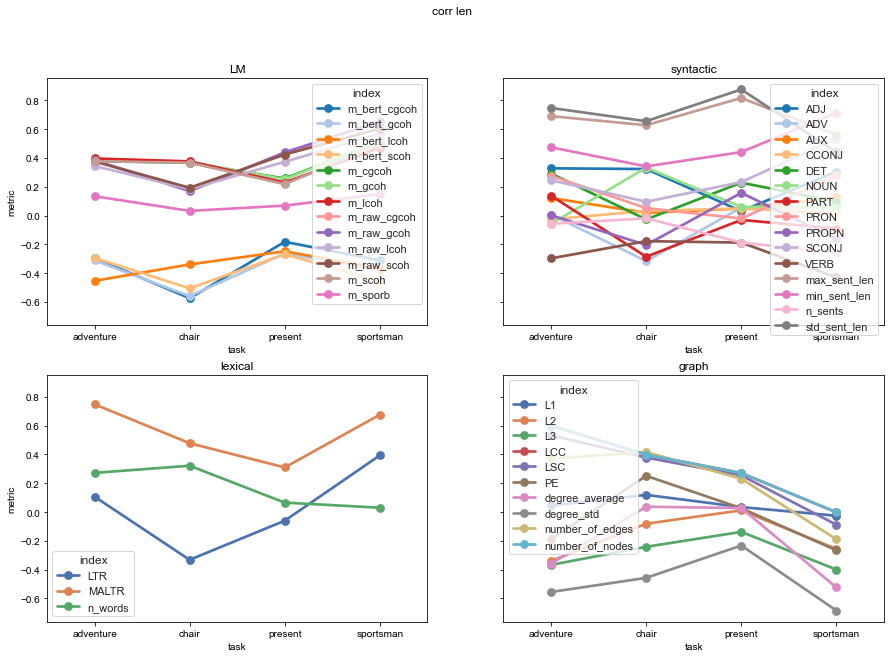

In [133]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
fig.suptitle('corr len')

pointplot(ex_df.loc['LM'], x="task", y="metric", hue="index", ax=axes[0, 0], palette='tab20')
axes[0, 0].set_title('LM')
pointplot(ex_df.loc['syntactic'], x="task", y="metric", hue="index", ax=axes[0, 1], palette='tab20')
axes[0, 1].set_title('syntactic')
pointplot(ex_df.loc['lexical'], x="task", y="metric", hue="index", ax=axes[1, 0])
axes[1, 0].set_title('lexical')
pointplot(ex_df.loc['graph'], x="task", y="metric", hue="index", ax=axes[1, 1])
axes[1, 1].set_title('graph');

# for ax, col in zip(axes[0], ('total', 'positive', 'negative')):
#     ax.set_title(col)

# for ax, row in zip(axes[:,0], ('NAP', 'Dep', 'HC')):
#     ax.set_ylabel(row, rotation=0, size='large')

## Corr corrected for length

In [134]:
compute_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'mean_sent_len'),
                    column_names=['sent len'], target_name='panss', add_sq=False)[0]

0.13965153537595465

In [135]:
compute_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'AUX'),
                    column_names=['sent len'], target_name='panss', add_sq=False)[0]

0.05067787087225517

In [136]:
compute_ortogonolized_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'),
                                  column_names=['sent len'], target_name='panss', add_sq=False)[0]

0.05601521546776389

In [137]:
scale_cols = [('target', x) for x in ['panss_pos', 'panss_neg', 'panss_o', 'panss_total']]

#### compare

In [138]:
# test_two_groups = ('sz', 'control_psy')
# groups = merge_df[merge_df[('target', 'target', 'diagnosis.type')].isin(test_two_groups)]
# chair_group = task_data(groups, 'chair')
# chair_group[('target', 'group')] = chair_group[('target', 'diagnosis.type')].apply(lambda x: 0 if x =='control_psy' else 1)


In [139]:
# a = 0.001
# s_t, res_t = display_group_test(chair_group, cols_tasks, ('target', 'diagnosis.type'), stats.ttest_ind, stat_name='t', alpha=a)

In [140]:
# s_panss, r_panss = display_test(chair, cols_tasks, ('target','panss_total'), stats.pearsonr, stat_name='r', alpha=a)
# s_panss_pos, r_panss_pos = display_test(chair, cols_tasks, ('target', 'panss_pos'), stats.pearsonr, stat_name='r', alpha=a)
# s_panss_neg, r_panss_neg = display_test(chair, cols_tasks, ('target','panss_neg'), stats.pearsonr, stat_name='r', alpha=a)
# s_panss_o, r_panss_o = display_test(chair, cols_tasks, ('target', 'panss_o'), stats.pearsonr, stat_name='r', alpha=a)
# combined_corr = pd.concat([res_t, r_panss, r_panss_pos, r_panss_neg, r_panss_o], 
#                      keys= ['t_test'] + [s[1] for s in scale_cols], 
#                      names=["scale"], axis=1)

In [141]:
# combined_corr[('mean', 'abs_r')] = combined_corr[[(scale[1], 'abs_r') for scale in scale_cols]].mean(axis=1)
# mean_abs_r = combined_corr.pop(('mean', 'abs_r'))
# combined_corr.insert(0, ('mean', 'abs_r'), mean_abs_r) 

In [142]:
# # combined_corr[[(scale, 'abs_r') for scale in ["saps34", "sans12", "panss", "panss_pos", "panss_neg", "panss_o"]]].mean(axis=1)
# t_p_n_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in ['panss_pos', 'panss_neg']], axis=1).mean(axis=1)
# mean_rank = pd.concat([combined_corr[(scale[1], 'abs_r')].rank(ascending=False) for scale in scale_cols], axis=1).mean(axis=1)
# combined_corr.insert(1, ('mean', 'rank'), mean_rank) 
# combined_corr.insert(2, ('mean', 'rank_abs'), mean_rank.rank()) 
# combined_corr.insert(1, ('mean', 'tpn_rank'), t_p_n_rank) 
# combined_corr.insert(2, ('mean', 'tpn_rank_abs'), t_p_n_rank.rank()) 

# style(combined_corr.sort_values(('mean', 'rank'))[['mean', 't_test']])

In [143]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_coefficient(chair, ('target', 'panss_total'), ('syntactic', 'mean_sent_len'), col)[0]
# combined_corr.insert(1, ('panss', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [144]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_coefficient(chair, ('target', 'panss_pos'), ('syntactic', 'mean_sent_len'), col)[0]
# combined_corr.insert(1, ('panss_pos', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [145]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_coefficient(chair, ('target', 'panss_neg'), ('syntactic', 'mean_sent_len'), col)[0]
# combined_corr.insert(1, ('panss_neg', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [146]:
# cols_dict = {}
# for col in cols_tasks:
#     cols_dict[col[1]] = compute_ortogonolized_logit(chair_group, ('target', 'group'), ('syntactic', 'mean_sent_len'), col)
# combined_corr.insert(1, ('t_test', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [147]:
# t_p_n_corr_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'r_corrected_for_mean_len')].rank(ascending=False) for scale in ['panss_pos', 'panss_neg']], axis=1).mean(axis=1)
# combined_corr.insert(1, ('mean', 'tpn_rank_corr'), t_p_n_corr_rank) 
# combined_corr.insert(2, ('mean', 'tpn_rank_corr_abs'), t_p_n_corr_rank.rank()) 

In [148]:
## combined_corr.sort_values(('mean', 'tpn_rank_corr'), ascending=True).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

## bootstrap

In [149]:
def draw_sample_with_replacement(df, seed=None):
    if seed:
        random.seed(seed)
    length = len(df.index)
    idxs = choices(range(length), k=length)
    return df.iloc[idxs, :]

In [150]:
# dict_scales_sapmles = {scale[1]: {metric: [] for metric in cols_tasks} for scale in scale_cols}
# dict_scales_raws = {scale[1]: {metric: [] for metric in cols_tasks} for scale in scale_cols}
# for i in tqdm(range(1000)):
#     sample = draw_sample_with_replacement(chair, seed=i)
#     for scale in scale_cols:
#         for col in cols_tasks:
#             if col != ('syntactic', 'mean_sent_len'):
#                 r_corr = compute_ortogonolized_coefficient(sample, scale, ('syntactic', 'mean_sent_len'), col)[0]
#                 r_raw = compute_coefficient(sample, scale, col)[0]
#                 dict_scales_raws[scale[1]][col].append(r_raw)
#                 dict_scales_sapmles[scale[1]][col].append(r_corr)
#             else:
#                 dict_scales_sapmles[scale[1]][col].append(np.nan)

In [151]:
# sample_df = pd.DataFrame()
# for scale in scale_cols:
#     scale = scale[1]
#     scale_metric_sd = {}
#     scale_metric_md = {}
#     scale_metric_mn = {}
#     scale_metric_cov = {}
#     scale_metric_diff = {}
#     scale_metric_q25 = {}
#     scale_metric_q75 = {}
#     for col in cols_tasks:
#         if col != ('syntactic', 'mean_sent_len'):
#             scale_metric_sd[col] = np.std(dict_scales_sapmles[scale][col])
#             scale_metric_md[col] = np.median(dict_scales_sapmles[scale][col])
#             scale_metric_mn[col] = np.mean(dict_scales_sapmles[scale][col])
#             scale_metric_q25[col] = np.quantile(dict_scales_sapmles[scale][col], 0.25)
#             scale_metric_q75[col] = np.quantile(dict_scales_sapmles[scale][col], 0.75)
#             scale_metric_cov[col] = np.std(dict_scales_sapmles[scale][col]) / np.mean(dict_scales_sapmles[scale][col])
#             scale_metric_diff[col] = np.mean(dict_scales_sapmles[scale][col]) / np.mean(dict_scales_raws[scale][col])
            
#     sample_df[(scale, 'md')] = pd.Series(scale_metric_md)
#     sample_df[(scale, 'mn')] = pd.Series(scale_metric_mn)
#     sample_df[(scale, 'sd')] = pd.Series(scale_metric_sd)
#     sample_df[(scale, 'cov')] = pd.Series(scale_metric_cov)
#     sample_df[(scale, 'dif')] = pd.Series(scale_metric_diff)
#     sample_df[(scale, 'q25')] = pd.Series(scale_metric_q25)
#     sample_df[(scale, 'q75')] = pd.Series(scale_metric_q75)

In [152]:
# sample_df.columns = pd.MultiIndex.from_tuples(sample_df.columns, names=('scale', 'res'))
# style(sample_df)

In [153]:
def t_test(df, column, target_column, test=stats.ttest_ind, nan_policy='omit', stat_name='x', alpha=0.05,
           group_names=None):
    if group_names is None:
        group_names = df[target_column].dropna().unique().tolist()
        assert len(group_names) == 2, 'only two group tests are supported'

    r, p = test(df[df[target_column] == group_names[1]][column],
                df[df[target_column] == group_names[0]][column], nan_policy=nan_policy)
    return r

In [154]:
def bootstrap(df, cols_av, scale_cols, N, col_to_correct_for=('syntactic', 'mean_sent_len'), group=None, 
             ordered_tgt=[('target', 'dep.severity'), ('target', 'td.severity')]):
    o_tgt = tuple((f'ps_r_{o[1]}' for o in ordered_tgt))
    res_c = ('sample_corr', 'sample_raw', 'r', 't', 'r_corr_w_control') + o_tgt
    dict_scales_sapmles = {k: {scale: {metric: [] for metric in cols_av} for scale in scale_cols} for k in res_c}
    for i in tqdm(range(N)):
        sample = draw_sample_with_replacement(df, seed=i)
        scale_independent = {k: {metric: np.nan for metric in cols_av} for k in ('t', 'r_corr_w_control') + o_tgt}
        for col in cols_av:
            if group:
                t_test_res = ttest_select(sample, ('sz', 'control_psy'), group)[col]
                scale_independent['t'][col] = t_test_res
            if col != col_to_correct_for:
                dropped_c = sample.dropna(subset=[col, col_to_correct_for])
                r_c = stats.pearsonr(dropped_c[col], dropped_c[col_to_correct_for])[0]
                scale_independent['r_corr_w_control'][col] = r_c
            for tgt in ordered_tgt:
                ps_r = compute_pseudo_rsquared_ordered(sample, tgt, [col])
                scale_independent[f'ps_r_{tgt[1]}'][col] = ps_r
            for scale in scale_cols:
                r_raw = compute_coefficient(sample, scale, col)[0]
                dict_scales_sapmles['sample_raw'][scale][col].append(r_raw)
                
                dropped = sample.dropna(subset=[col, scale])
                r = stats.pearsonr(dropped[col], dropped[scale])[0]
                dict_scales_sapmles['r'][scale][col].append(r)
                
                if col != col_to_correct_for:
                    r_corr = compute_ortogonolized_coefficient(sample, scale, col_to_correct_for, col)[0]
                    dict_scales_sapmles['sample_corr'][scale][col].append(r_corr)
                
                for k in scale_independent:
                    dict_scales_sapmles[k][scale][col].append(scale_independent[k][col])
                
                
#         for scale in scale_cols:
#             for col in cols_av:
#                 if group:
#                     t_test_res = ttest_select(sample, ('sz', 'control_psy'), group)[col]
# #                     t_test(sample, col, group)
#                     dict_scales_sapmles['t'][scale][col].append(t_test_res)
                    
#                 r_raw = compute_coefficient(sample, scale, col)[0]
#                 dict_scales_sapmles['sample_raw'][scale][col].append(r_raw)
                
               
#                 dropped = sample.dropna(subset=[col, scale])
#                 r = stats.pearsonr(dropped[col], dropped[scale])
#                 dict_scales_sapmles['r'][scale][col].append(r)
                
                                
#                 if col != col_to_correct_for:
                    
#                     dropped_c = sample.dropna(subset=[col, col_to_correct_for])
#                     r_c = stats.pearsonr(dropped_c[col], dropped_c[col_to_correct_for])
#                     dict_scales_sapmles['r_corr_w_control'][scale][col].append(r_c)
                    
#                     r_corr = compute_ortogonolized_coefficient(sample, scale, col_to_correct_for, col)[0]
#                     dict_scales_sapmles['sample_corr'][scale][col].append(r_corr)
                    
#                 for o_tgt in ordered_tgt:
#                     ps_r = compute_pseudo_rsquared_ordered(sample, o_tgt, [col])
#                     dict_scales_sapmles[f'ps_r_{o_tgt[1]}'][scale][col].append(ps_r)

    return dict_scales_sapmles

In [155]:
# dict_scales_sapmles = bootstrap(chair, cols_tasks, scale_cols, 10, col_to_correct_for=('syntactic', 'mean_sent_len'), group='diagnosis.type')

In [156]:
# dict_scales_sapmles['t']

In [157]:
# reform = {(scale[1], measure): dict_scales_sapmles[measure][scale] for scale in scale_cols for measure in dict_scales_sapmles}

In [158]:
# pd.DataFrame(reform).applymap(np.nanmean).loc['LM']

#### expensive to compute

In [159]:
# dict_scales_sapmles = aplly_to_all_tasks(merge_df, bootstrap, cols_av=cols_tasks, scale_cols=scale_cols, N=100, col_to_correct_for=('syntactic', 'mean_sent_len'), group='diagnosis.type')

In [160]:
# reform = {(task, scale[1], measure): dict_scales_sapmles[task][measure][scale] for scale in scale_cols for task in dict_scales_sapmles
#           for measure in dict_scales_sapmles[task]}

In [161]:
# with open('ru_task_scales_samples.pickle', 'wb') as f:
#     pickle.dump(reform, f)

In [162]:
with open('ru_task_scales_samples.pickle', 'rb') as f:
    reform = pickle.load(f)

In [163]:
median_bootstrap = pd.DataFrame(reform).applymap(np.nanmedian)

In [164]:
style(median_bootstrap.loc['syntactic', ('chair', 'panss_pos')])

,sample_corr,sample_raw,r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
ADJ,0.010532,0.013411,-0.076362,0.053592,0.325833,0.085309,0.026047
ADV,0.020915,0.025874,0.140070,-0.087733,-0.311614,0.019110,0.045587
AUX,0.059992,0.060592,0.243569,-0.015047,0.019248,0.019715,0.024493
CCONJ,0.022263,0.028271,-0.111782,0.057062,0.010296,0.061430,0.026098
DET,0.013736,0.015713,0.013498,0.050479,-0.017698,0.007702,0.018925
NOUN,0.123651,0.166719,-0.408312,0.256387,0.313105,0.017486,0.171259
PART,0.207206,0.256737,0.506691,-1.363321,-0.269517,0.019663,0.236460
PRON,0.048901,0.041416,0.193625,0.157770,0.055899,0.028822,0.054124
PROPN,0.007405,0.012801,0.064853,-0.660168,-0.193122,0.020133,0.026539
SCONJ,0.067364,0.040534,0.152180,-0.043282,0.116521,0.017517,0.029798


In [165]:
ex_df = median_bootstrap.loc['LM', ('chair', 'panss_pos')]
style(ex_df)

,sample_corr,sample_raw,r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
m_bert_cgcoh,0.049219,0.062860,0.250715,-0.371284,-0.579555,0.013645,0.050751
m_bert_gcoh,0.041186,0.051422,0.226763,-0.113742,-0.578475,0.015541,0.041970
m_bert_lcoh,0.019615,0.017024,0.119175,0.070018,-0.324327,0.012179,0.019722
m_bert_scoh,0.039981,0.039751,0.197050,0.016435,-0.496487,0.013258,0.045104
m_cgcoh,0.123469,0.021576,0.141459,0.320895,0.353563,0.064104,0.024259
m_gcoh,0.111276,0.019053,0.120611,0.421565,0.362633,0.077151,0.022288
m_lcoh,0.075366,0.013016,0.097685,0.659807,0.366292,0.075326,0.021217
m_raw_cgcoh,0.115199,0.058889,0.237650,-0.075159,0.180602,0.023307,0.038451
m_raw_gcoh,0.062687,0.024085,0.136444,0.197955,0.176637,0.038494,0.026372
m_raw_lcoh,0.053215,0.025479,0.128393,0.518596,0.195603,0.051909,0.025886


In [166]:
def map_model(m):
    if 'bert' in m or 'sporb' in m or 'sprob' in m:
        return 'bert'
    elif 'raw' in m:
        return 'w2v_raw'
    else:
        return 'w2v'
    
def prep_LM_pointplot_data(df, plot_abs=False):
#     df.drop(index='m_sporb', inplace=True)
    if plot_abs:
        df = df.applymap(abs)
    df['model'] = [map_model(m) for m in df.index]
    df['metric'] = [x.split('_')[-1] for x in df.index]
    return df

In [167]:
def prep_LM_pointplot_errobar_data(df, col, plot_abs=False):
    r = np.concatenate(df[col].to_numpy())
    if plot_abs:
        r = map(abs, r)
    idx = np.concatenate([[x]*len(df[col][x]) for x in df[col].index])
    d = pd.DataFrame(data=r, columns=[col])
    d['model'] = list(map(map_model, idx))
    d['metric'] = list(map(lambda x: x.split('_')[-1], idx))
    return d

In [168]:
def prep_LM_pointplot(df, col, plot_abs=False, use_errorbar=True):
    if not use_errorbar:
        return prep_LM_pointplot_data(df, plot_abs=plot_abs)
    else:
        return prep_LM_pointplot_errobar_data(df, col, plot_abs=plot_abs)

In [169]:
order=['bert', 'w2v', 'w2v_raw']

def plot_lm_tasks(df, title, scale, measure, order=order, plot_abs=False, use_errorbar=True,
                 figsize=(15, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    fig.suptitle(title)
    
    d = prep_LM_pointplot(df.loc['LM', ('chair', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d,x="model", y=measure, hue="metric", ax=axes[0, 0], order=order, use_errorbar=use_errorbar)
    axes[0, 0].set_title('chair')
    
    d = prep_LM_pointplot(df.loc['LM', ('adventure', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d, x="model", y=measure, hue="metric", ax=axes[0, 1], order=order, use_errorbar=use_errorbar)
    axes[0, 1].set_title('adventure')
    
    d = prep_LM_pointplot(df.loc['LM', ('present', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d, x="model", y=measure, hue="metric", ax=axes[1, 0], order=order, use_errorbar=use_errorbar)
    axes[1, 0].set_title('present')
    
    d = prep_LM_pointplot(df.loc['LM', ('sportsman', scale)], col=measure, plot_abs=plot_abs)
    pointplot(d, x="model", y=measure, hue="metric", ax=axes[1, 1], order=order, use_errorbar=use_errorbar);
    axes[1, 1].set_title('sportsman')
    if plot_abs:
        for ax in axes.reshape(-1): 
            ax.set_xlabel('abs ' + measure);

In [170]:
reformed_d_ = pd.DataFrame(reform).loc['LM', ('chair', 'panss_pos')]

In [171]:
d = prep_LM_pointplot_errobar_data(reformed_d_, 'r', plot_abs=True)

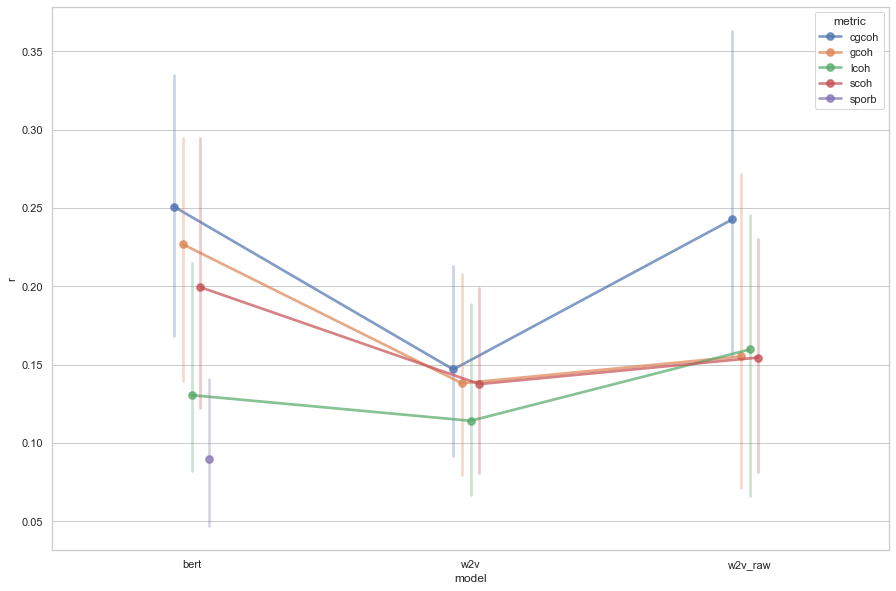

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pointplot(d, x="model", y="r", hue="metric", order=order, ax=ax, use_errorbar=True)

In [173]:
reformed_d = pd.DataFrame(reform)

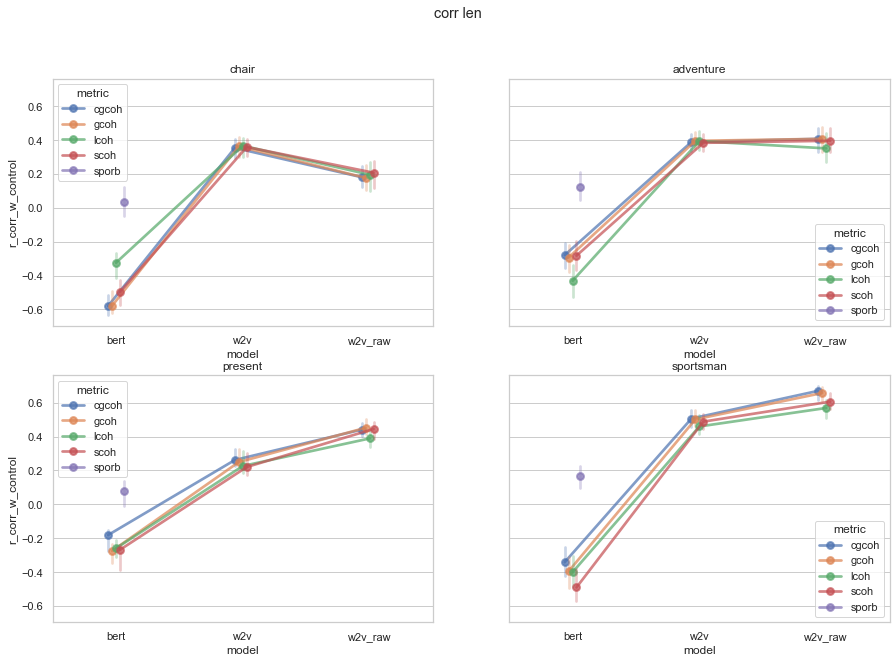

In [174]:
plot_lm_tasks(reformed_d, 'corr len', 'panss_pos', 'r_corr_w_control', use_errorbar=True, order=order)

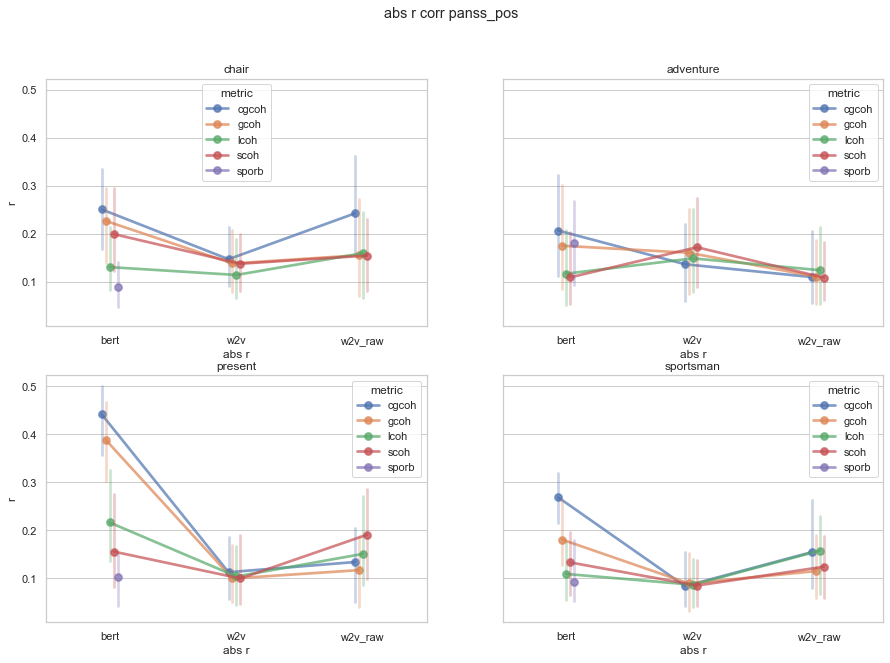

In [175]:
plot_lm_tasks(reformed_d, 'abs r corr panss_pos', 'panss_pos', 'r', 
              plot_abs=True, use_errorbar=True, order=order)

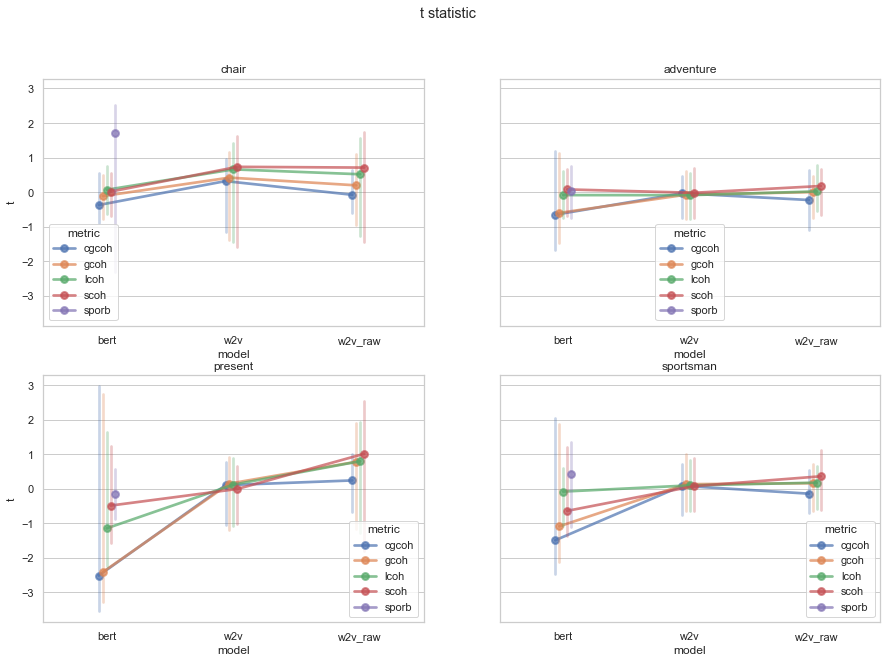

In [176]:
plot_lm_tasks(reformed_d, 't statistic', 'panss_o', 't', 
              use_errorbar=True, order=order)

In [177]:
def plot_all_LM(reformed_d, m_type='LM', path='/Users/galina.ryazanskaya/Downloads/thesis?/figures/ru', figsize=(15, 10), dpi = 150):
    plot_lm_tasks(reformed_d, 't', 'panss_o', 't', use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/model/t.png', dpi=dpi)
    
    plot_lm_tasks(reformed_d, 'abs r corr panss_pos', 'panss_pos', 'r', 
                  plot_abs=True, use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/model/abs_r_panss_pos.png', dpi=dpi)
    plot_lm_tasks(reformed_d, 'abs r corr panss_neg', 'panss_neg', 'r', 
                  plot_abs=True, use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/model/abs_r_panss_neg.png', dpi=dpi)
    plot_lm_tasks(reformed_d, 'abs r corr panss_o', 'panss_o', 'r', 
                  plot_abs=True, use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/model/abs_r_panss_o.png', dpi=dpi)
    
    plot_lm_tasks(reformed_d, 'corr len', 'panss_o', 'r_corr_w_control', 
                  use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/model/corr_len.png', dpi=dpi)
    
    plot_lm_tasks(reformed_d, 'pseudo r squared dep.severity', 'panss_o', 'ps_r_dep.severity', 
                  use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/model/ps_r_dep_severity.png', dpi=dpi)
    plot_lm_tasks(reformed_d, 'pseudo r squared td.severity', 'panss_o', 'ps_r_td.severity', 
                  use_errorbar=True, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/model/ps_r_td_severity.png', dpi=dpi)

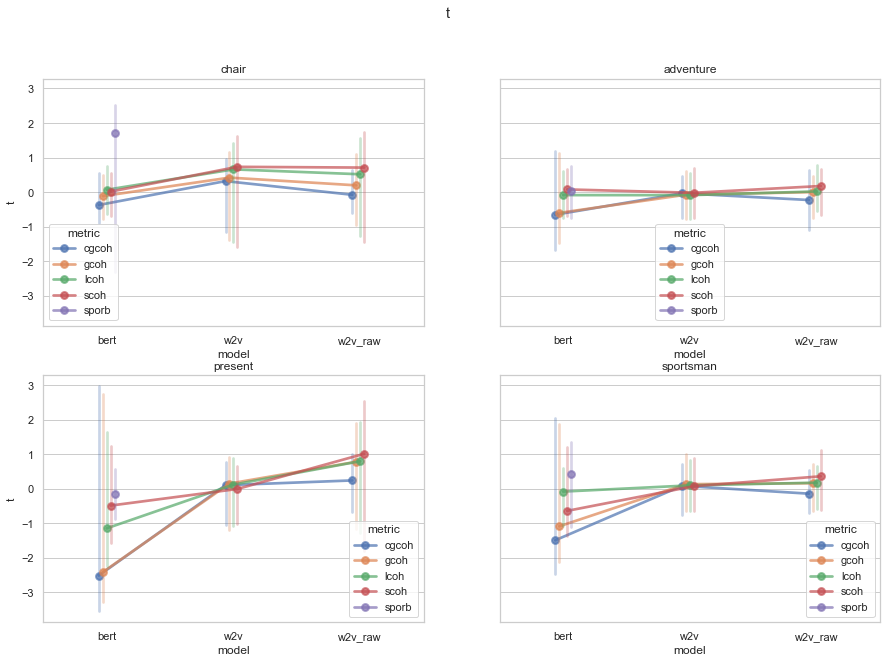

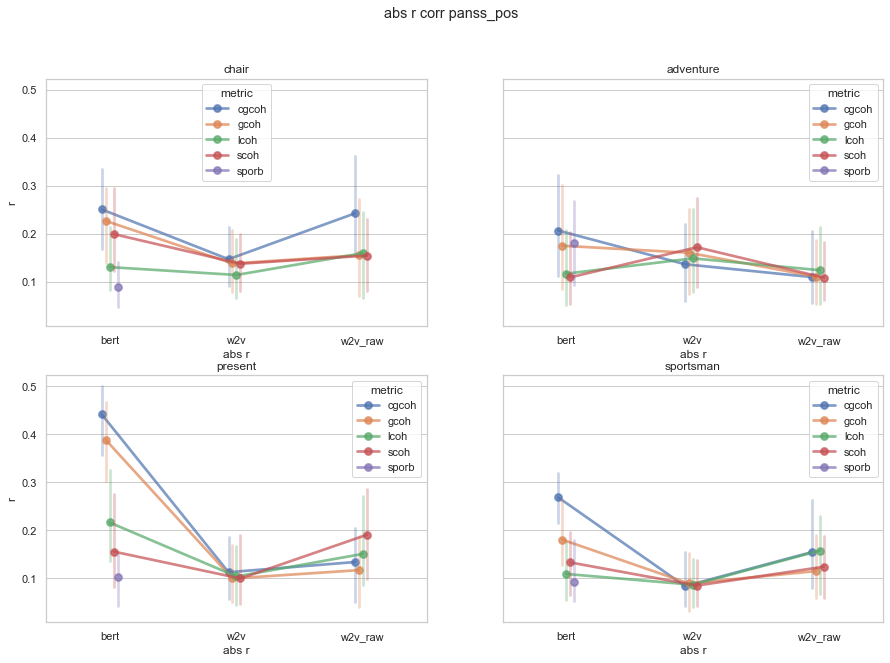

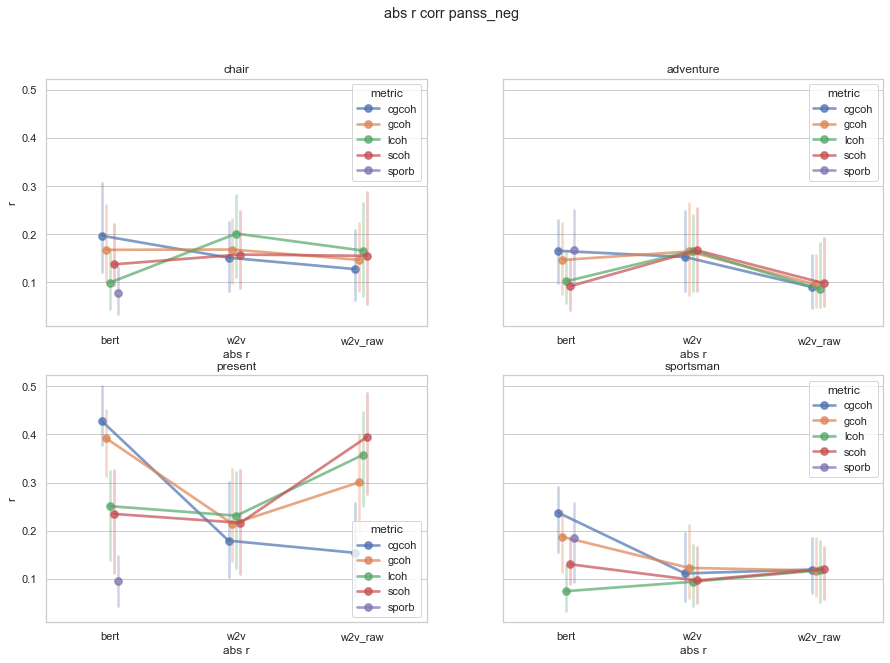

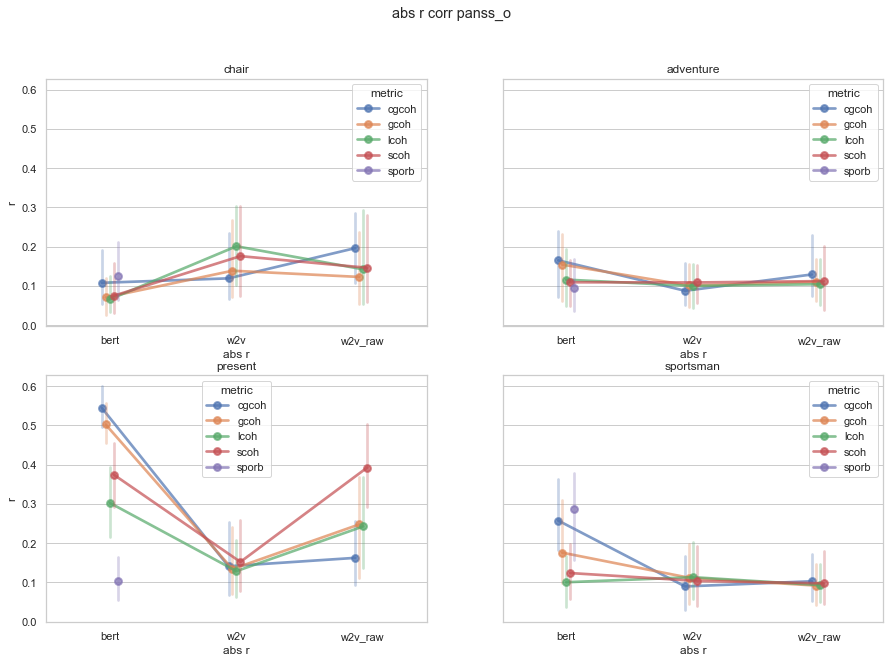

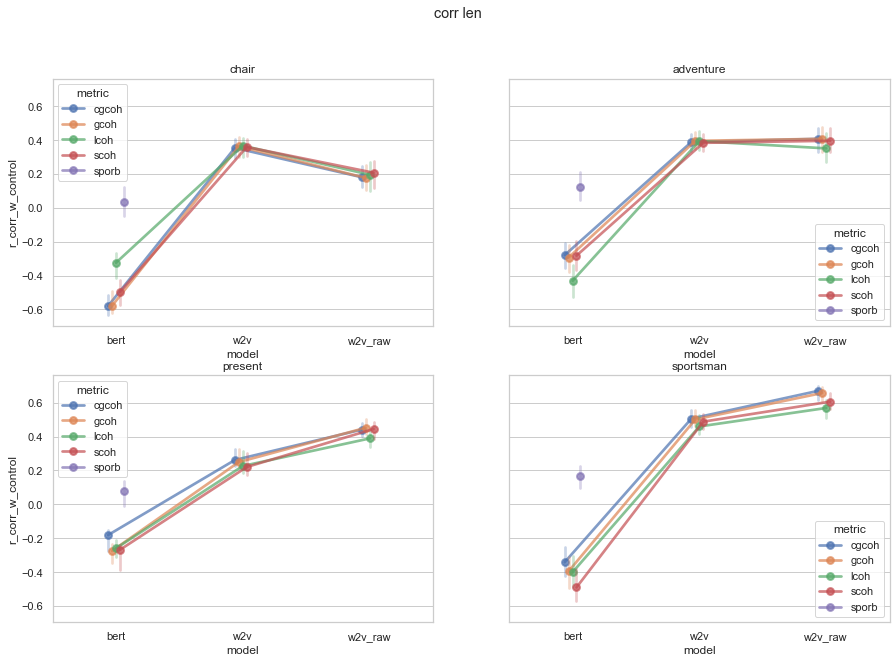

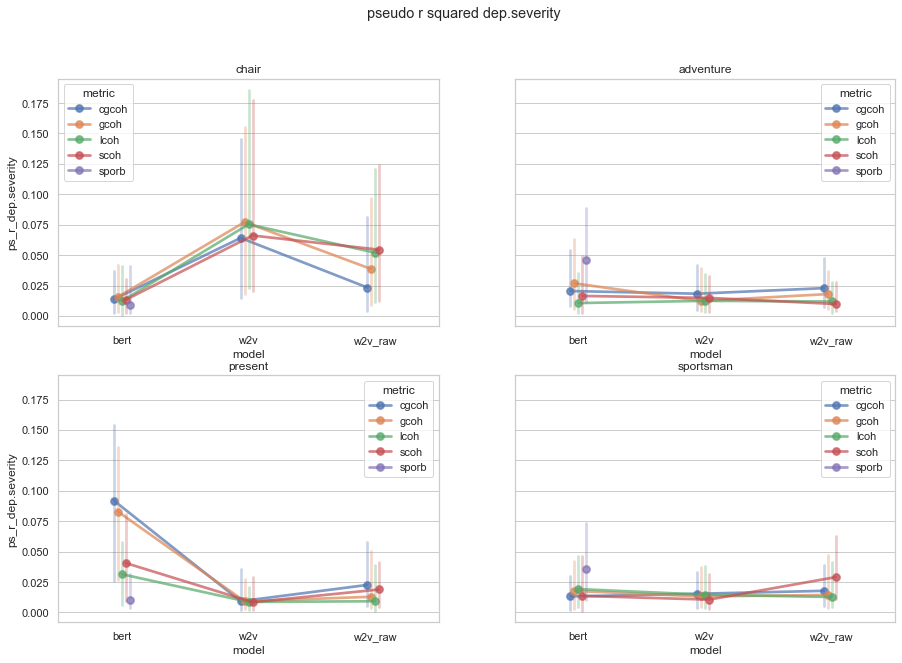

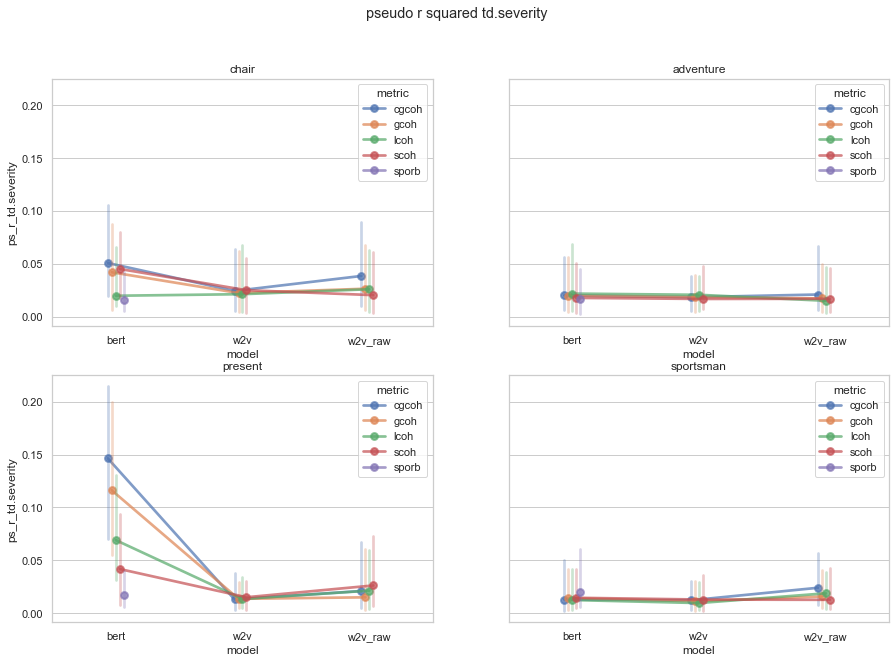

In [178]:
plot_all_LM(reformed_d)

In [179]:
def prep_synt_pointplot_errobar_data(df, col, plot_abs=False):
    r = np.concatenate(df[col].to_numpy())
    if plot_abs:
        r = map(abs, r)
    ex_d = reformed_d['chair', 'panss_pos', 'r'].loc['syntactic']
    r = np.concatenate(ex_d.to_numpy())
    idx = np.concatenate([[x]*len(ex_d[x]) for x in ex_d.index])
    d = pd.DataFrame(data=r, columns=['panss_pos'])
    d['metric'] = idx
    return d

In [180]:
def prep_synt_pointplot_errobar_data(df, col, plot_abs=False):
    r = np.concatenate(df[col].to_numpy())
    if plot_abs:
        r = map(abs, r)
    idx = np.concatenate([[x]*len(df[col][x]) for x in df[col].index])
    d = pd.DataFrame(data=r, columns=[col])
    d['metric'] = idx
    return d

In [181]:
def pointplot_synt(df, x, ax):
    sns.pointplot(
        data=df, x=x, y="metric",
        errorbar=("pi", 50), estimator='median', capsize=.0,
        linestyle="none", hue="metric", palette='tab20',
        err_kws={'alpha':0.3}, alpha=0.7, ax=ax);

In [182]:
d = prep_synt_pointplot_errobar_data(reformed_d['chair', 'panss_pos'].loc['syntactic'], 'r')

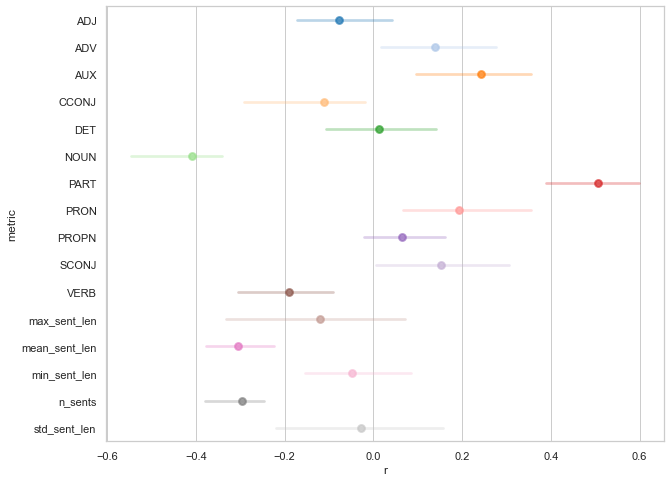

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
pointplot_synt(d, 'r', ax=ax)

In [185]:
def plot_horizontal_tasks(df, title, scale, measure, m_type='syntactic', plot_abs=False, figsize=(18, 12)):
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    fig.suptitle(title)

    pointplot_synt(prep_synt_pointplot_errobar_data(df.loc[m_type, ('chair', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[0, 0])
    axes[0, 0].set_title('chair')
    pointplot_synt(prep_synt_pointplot_errobar_data(df.loc[m_type, ('adventure', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[0, 1])
    axes[0, 1].set_title('adventure')
    pointplot_synt(prep_synt_pointplot_errobar_data(df.loc[m_type, ('present', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[1, 0])
    axes[1, 0].set_title('present')
    pointplot_synt(prep_synt_pointplot_errobar_data(df.loc[m_type, ('sportsman', scale)], 
                                                    col=measure, plot_abs=plot_abs), 
                   x=measure, ax=axes[1, 1])
    axes[1, 1].set_title('sportsman')
    if plot_abs:
        for ax in axes.reshape(-1): 
            ax.set_xlabel('abs ' + measure);

In [191]:
def plot_all(reformed_d, m_type='syntactic', path='/Users/galina.ryazanskaya/Downloads/thesis?/figures/ru', 
             figsize=(18, 12), plot_abs=True, dpi=150):
    plot_horizontal_tasks(reformed_d, 't', 'panss_o', 't', m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/t.png', dpi=dpi)
    
    ab = 'abs_' if plot_abs else ''
    plot_horizontal_tasks(reformed_d, f'{ab}r corr panss_pos', 'panss_pos', 'r', 
                          plot_abs=plot_abs, m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/{ab}r_panss_pos.png', dpi=dpi)
    plot_horizontal_tasks(reformed_d, f'{ab}r corr panss_neg', 'panss_neg', 'r', 
                          plot_abs=plot_abs, m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/{ab}r_panss_neg.png', dpi=dpi)
    plot_horizontal_tasks(reformed_d, f'{ab}r corr panss_o', 'panss_o', 'r', 
                          plot_abs=plot_abs, m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/{ab}r_panss_o.png', dpi=dpi)
    
    plot_horizontal_tasks(reformed_d, 'corr len', 'panss_o', 'r_corr_w_control', 
                          m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/corr_len.png', dpi=dpi)
    
    plot_horizontal_tasks(reformed_d, 'pseudo r squared dep.severity', 'panss_o', 'ps_r_dep.severity', 
                          m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/ps_r_dep_severity.png', dpi=dpi)
    plot_horizontal_tasks(reformed_d, 'pseudo r squared td.severity', 'panss_o', 'ps_r_td.severity', 
                          m_type=m_type, figsize=figsize)
    plt.savefig(f'{path}/{m_type}/ps_r_td_severity.png', dpi=dpi)

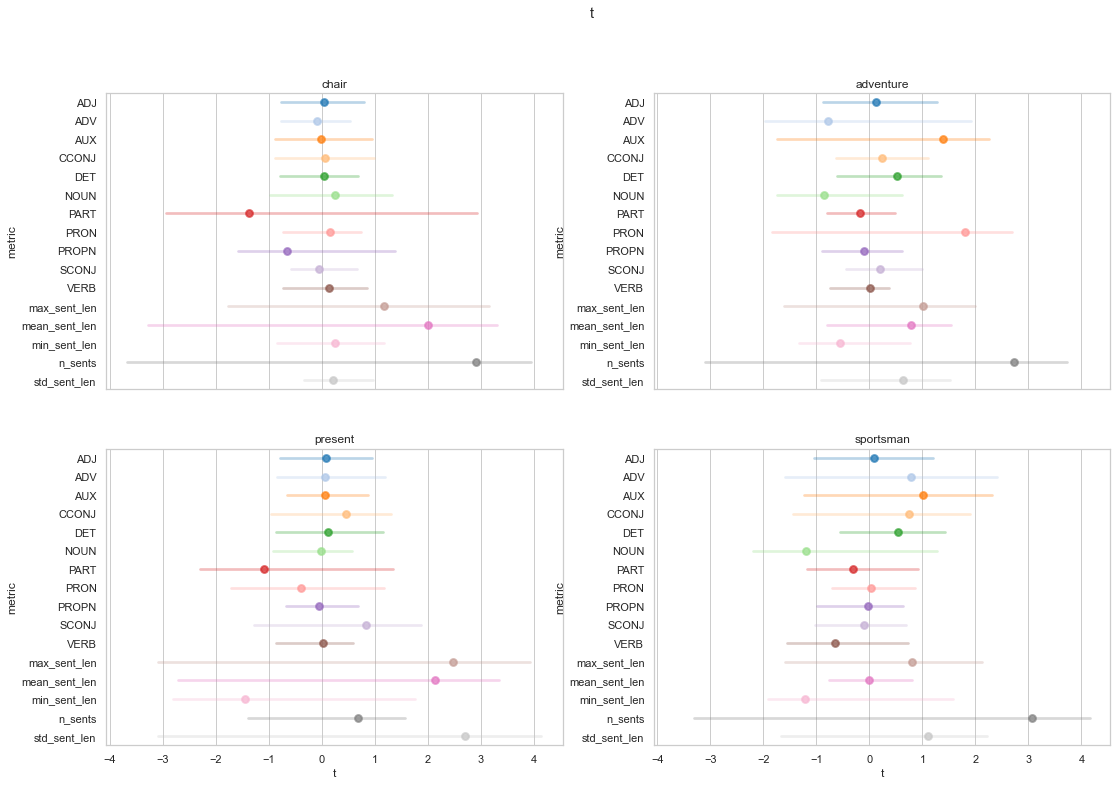

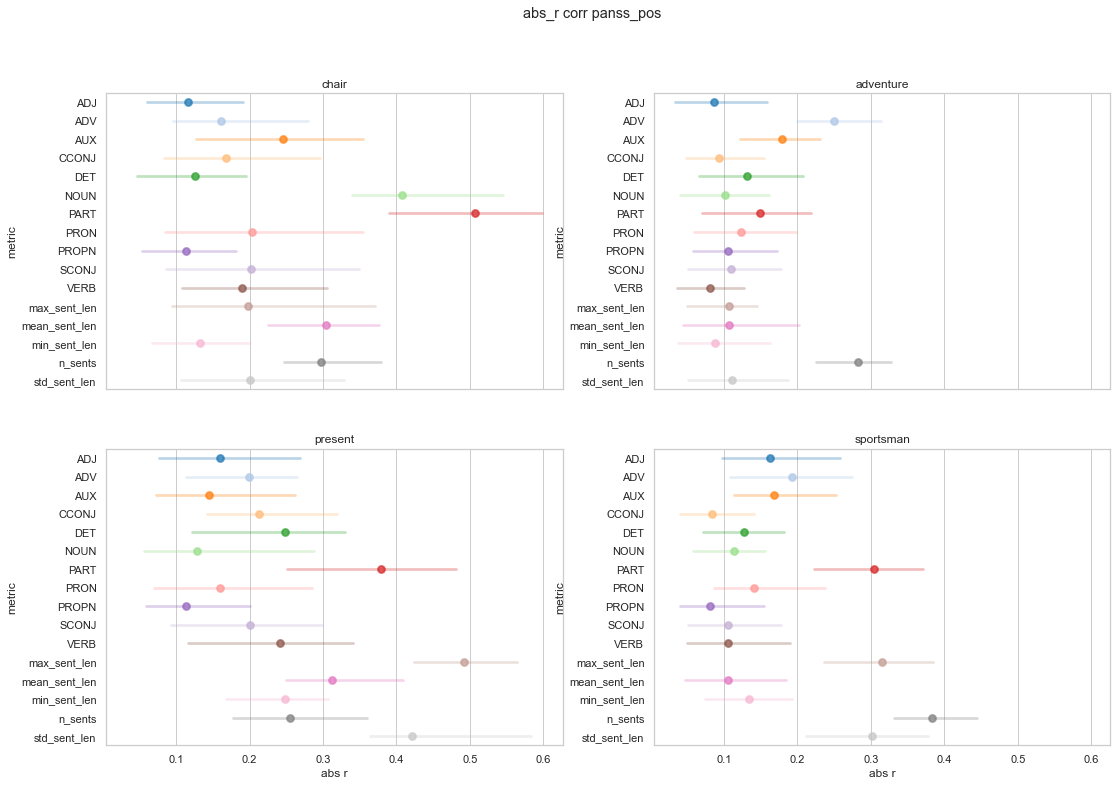

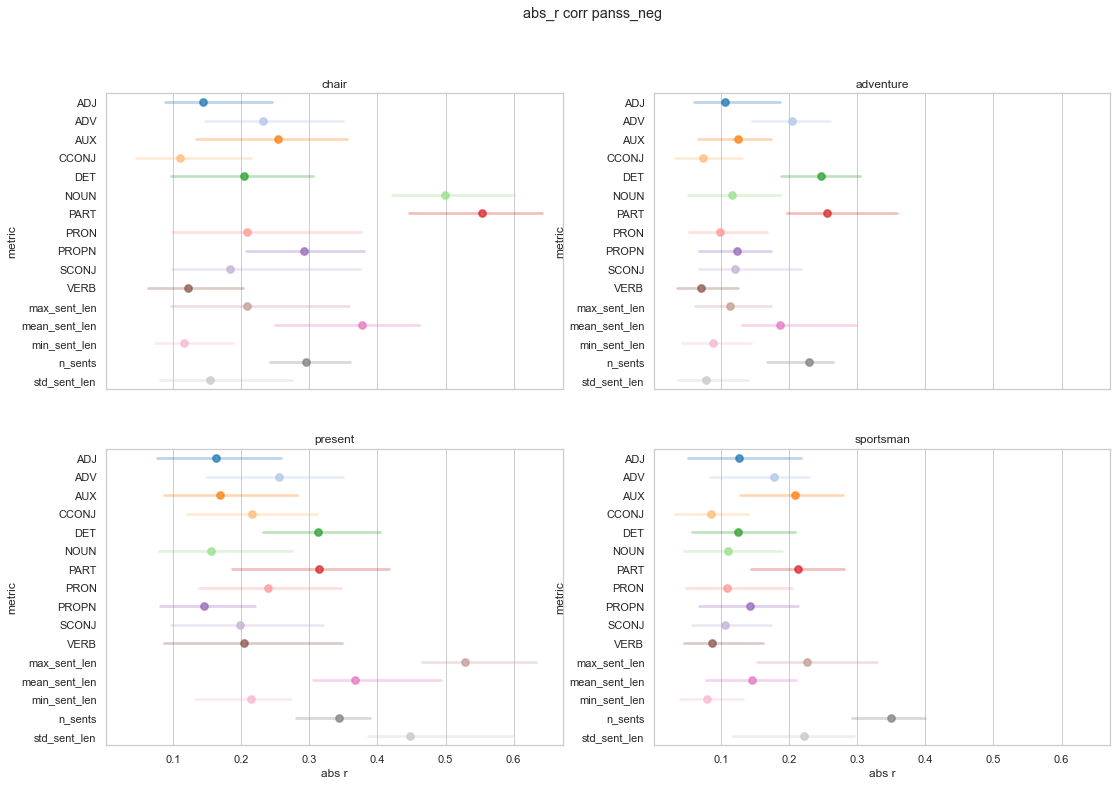

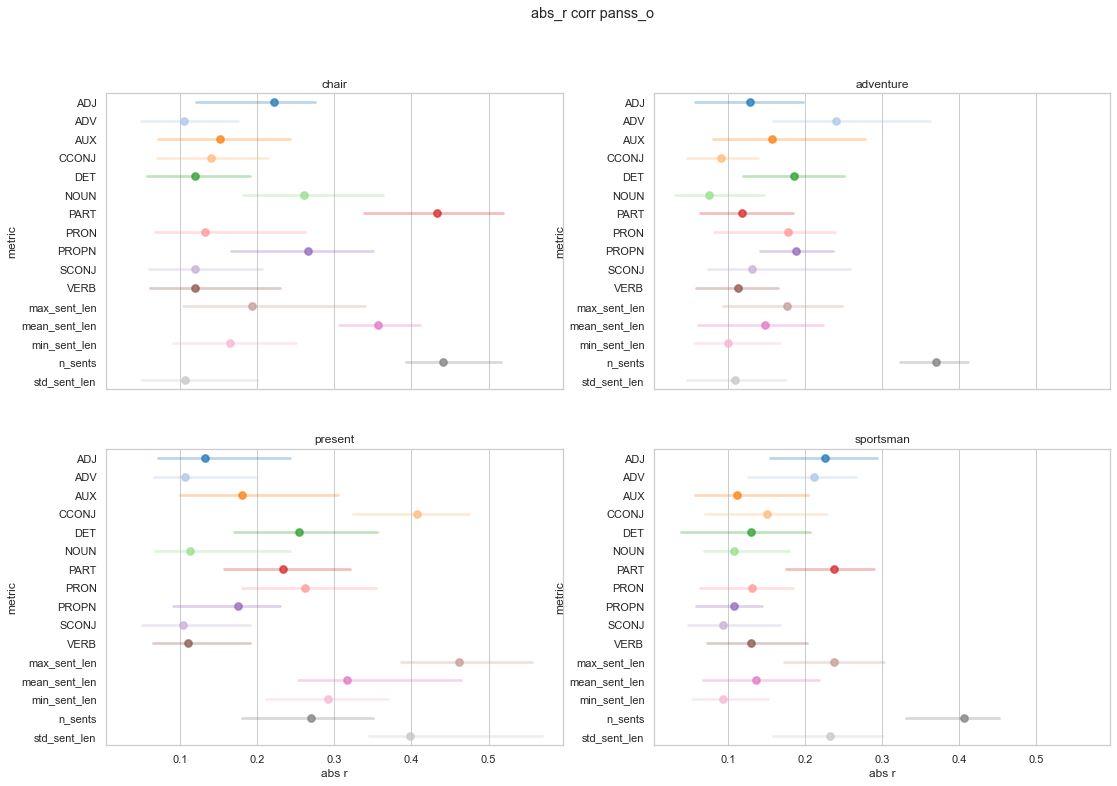

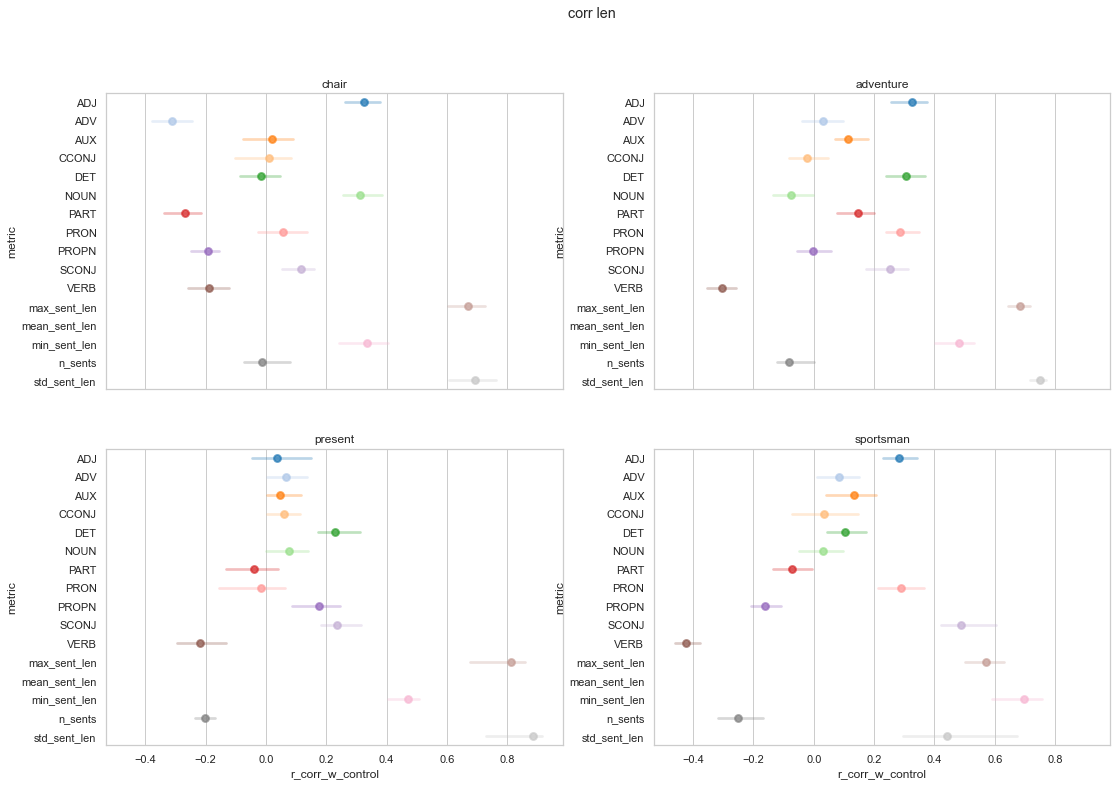

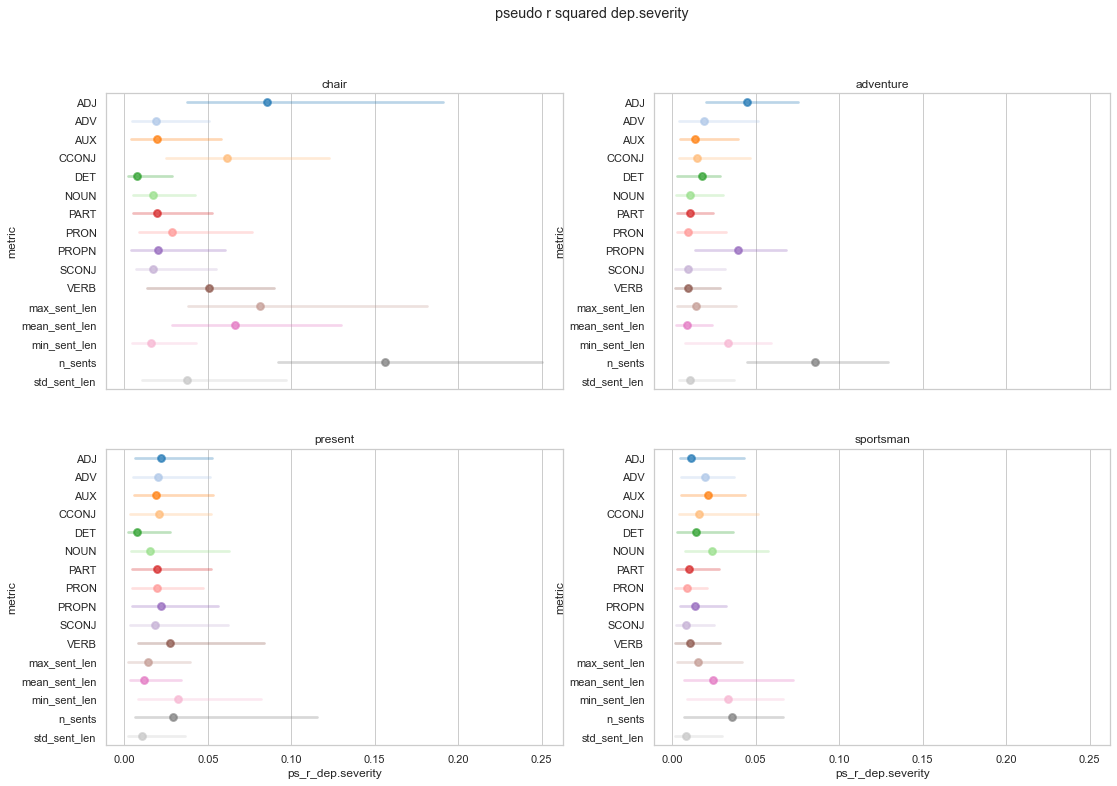

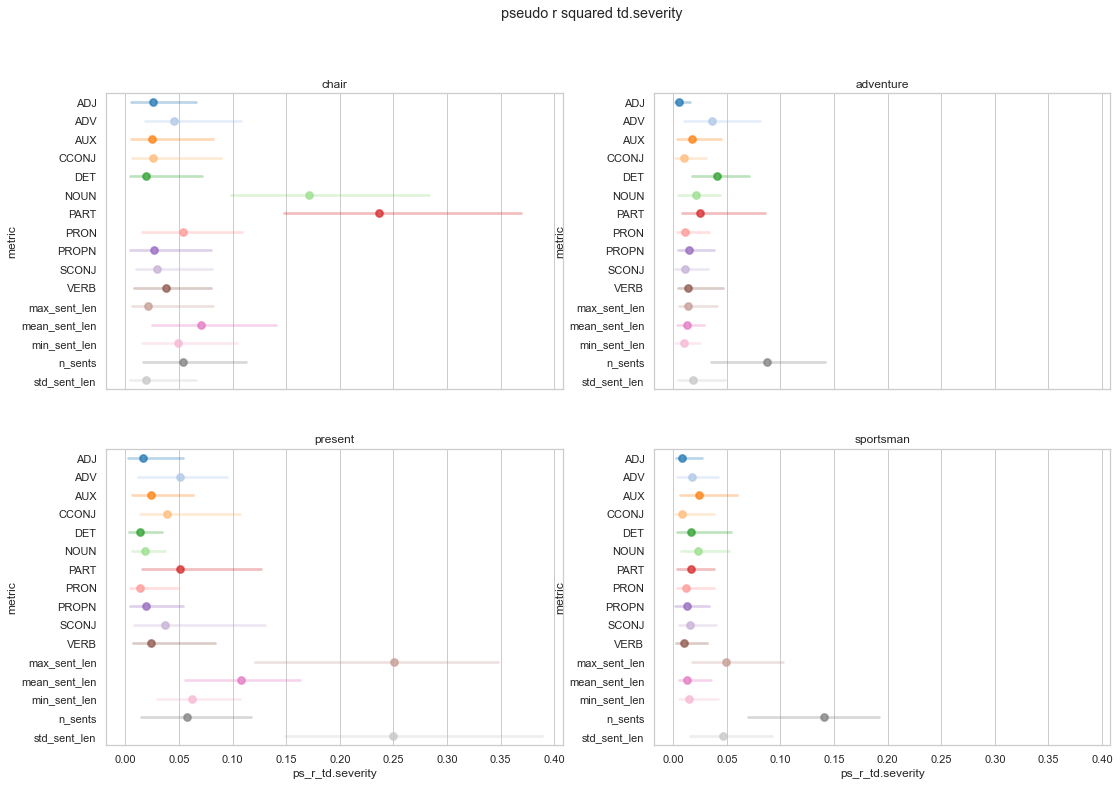

In [188]:
plot_all(reformed_d, plot_abs=True)

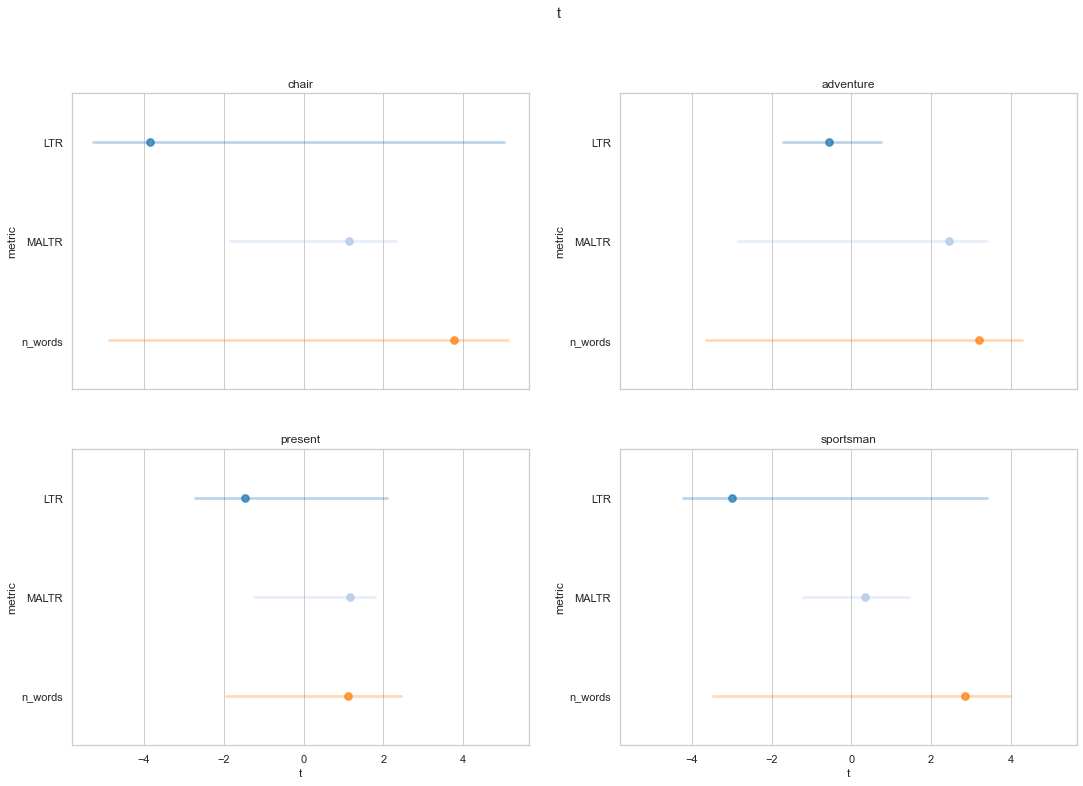

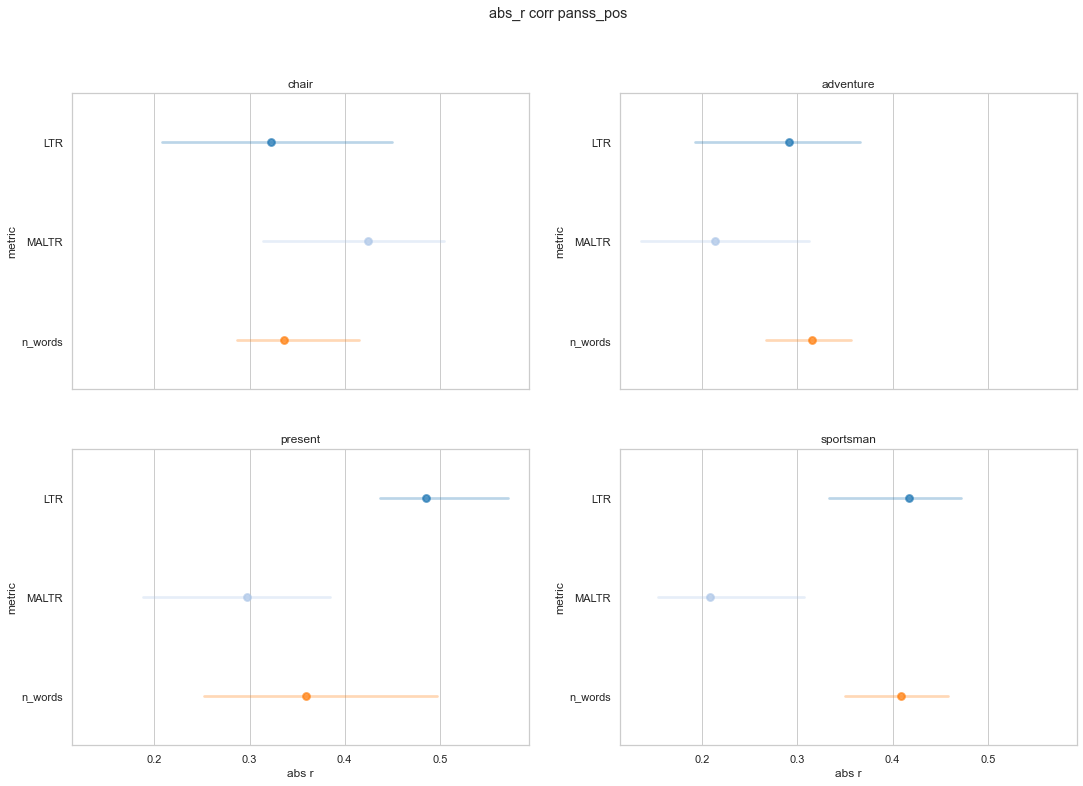

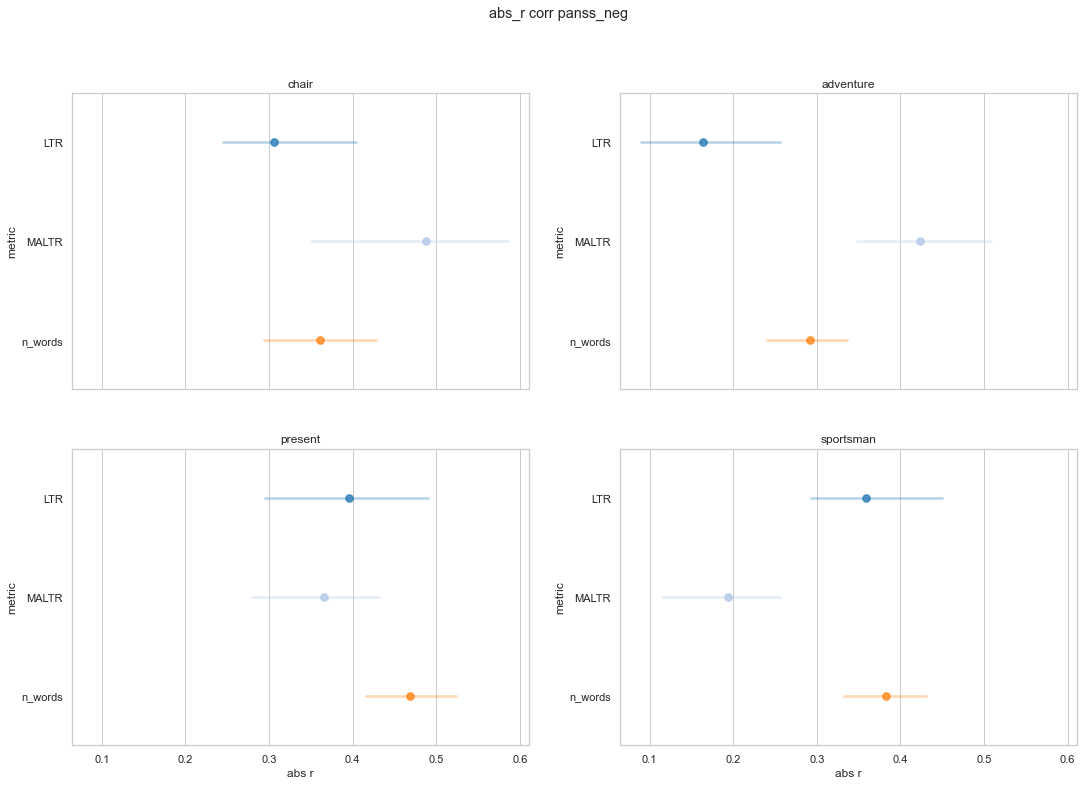

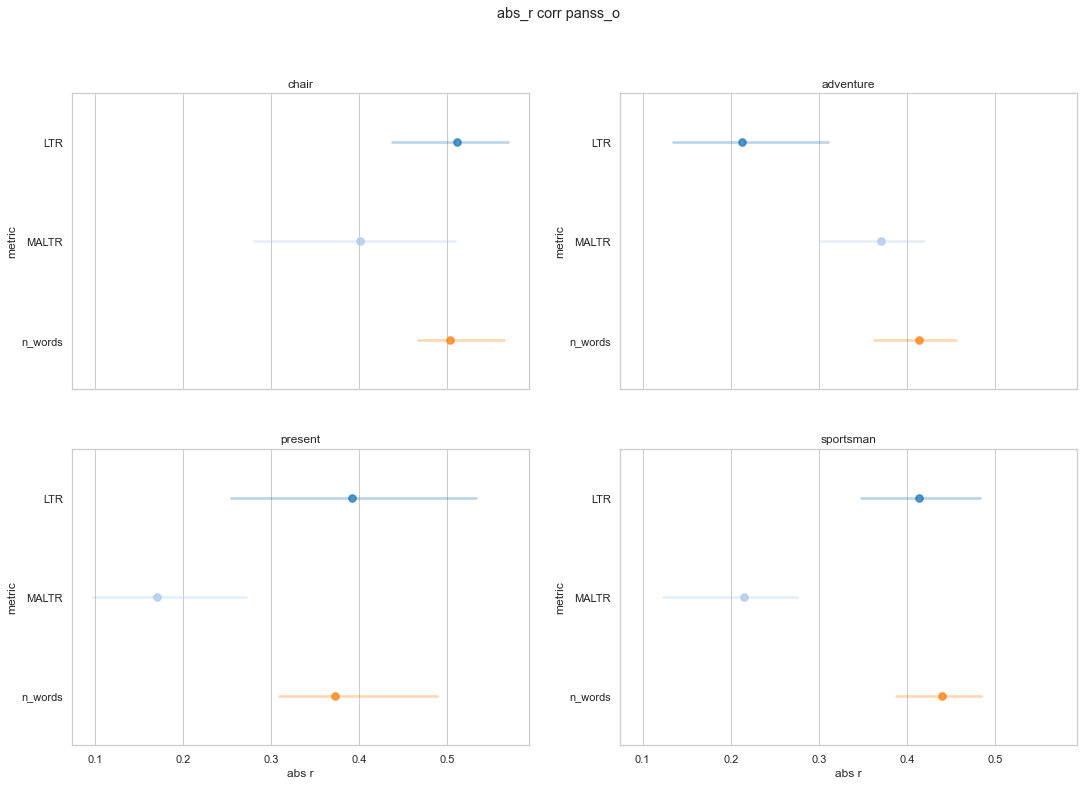

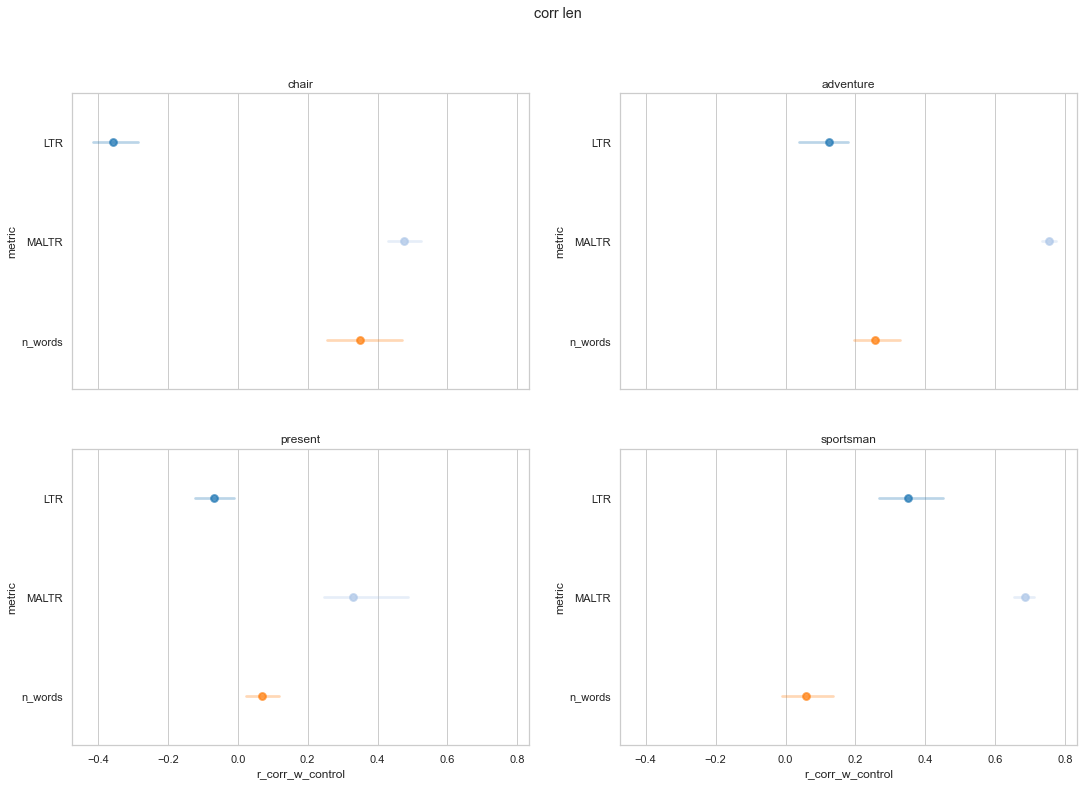

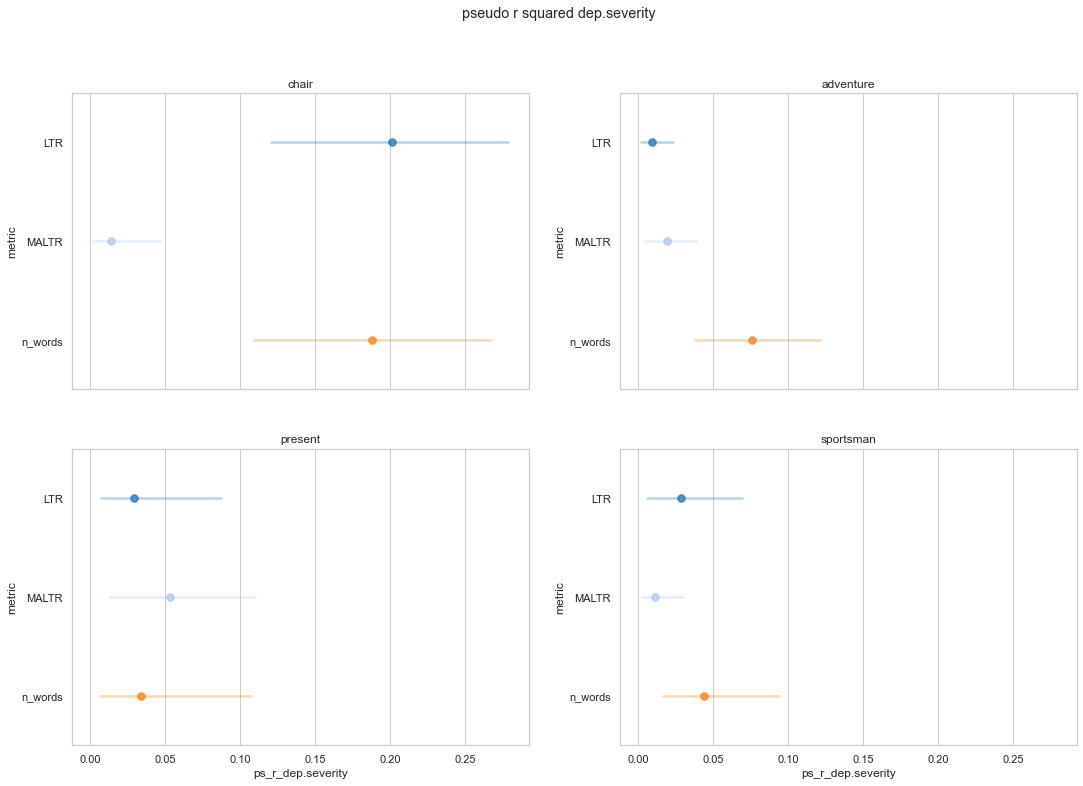

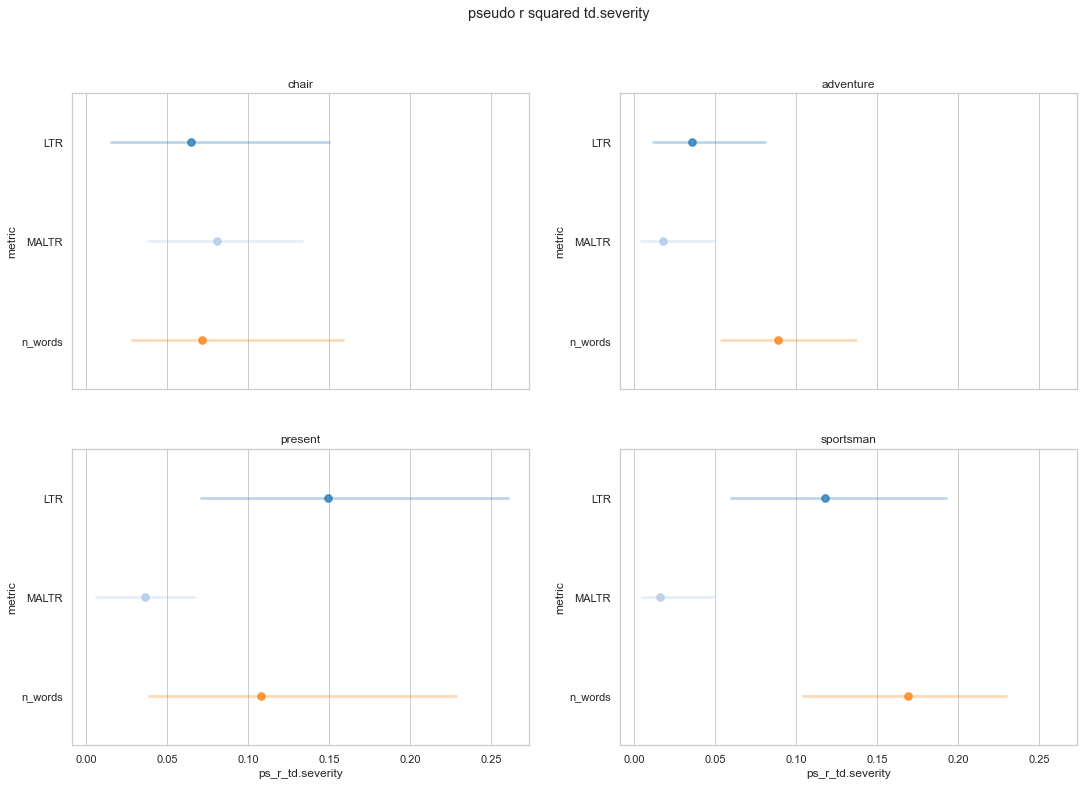

In [187]:
plot_all(reformed_d, 'lexical', plot_abs=True)

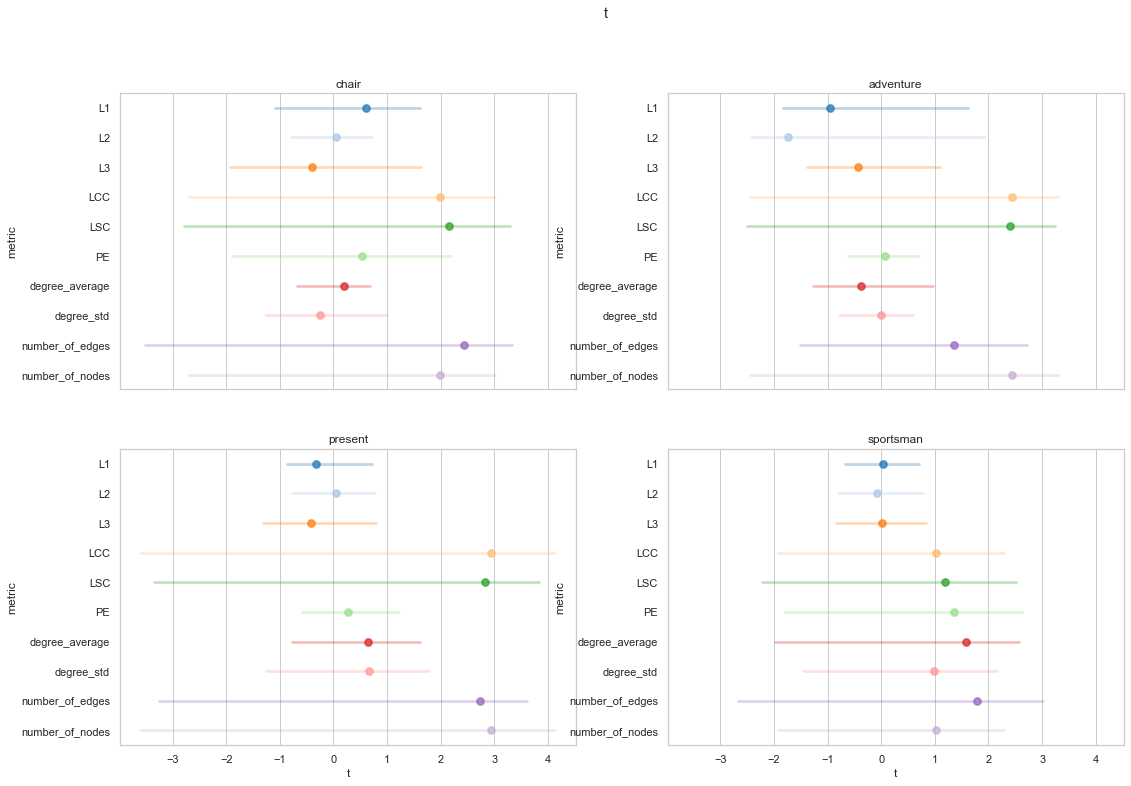

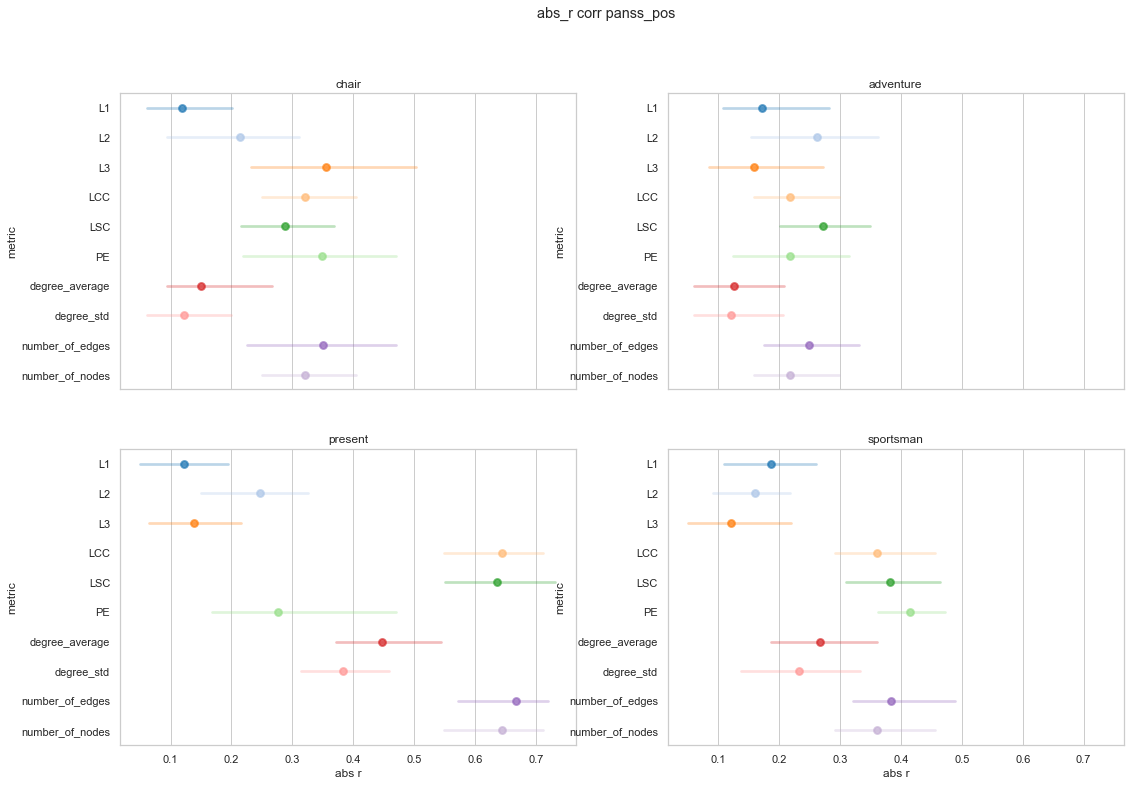

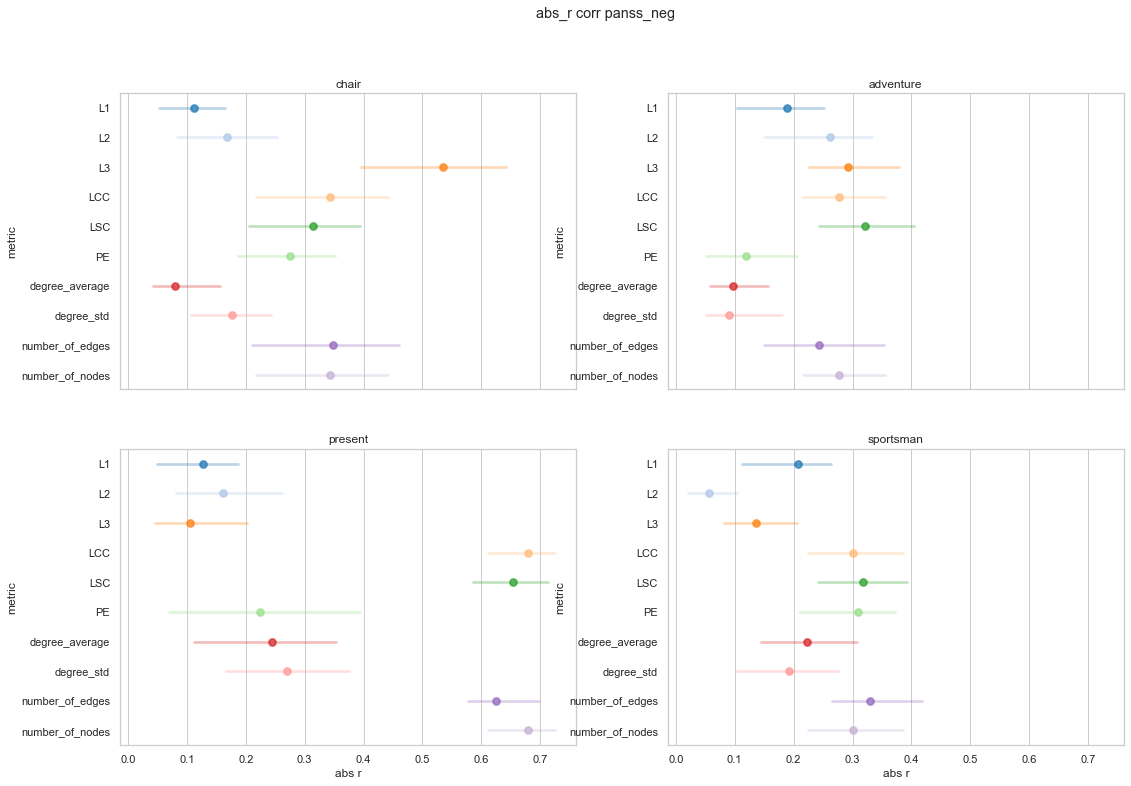

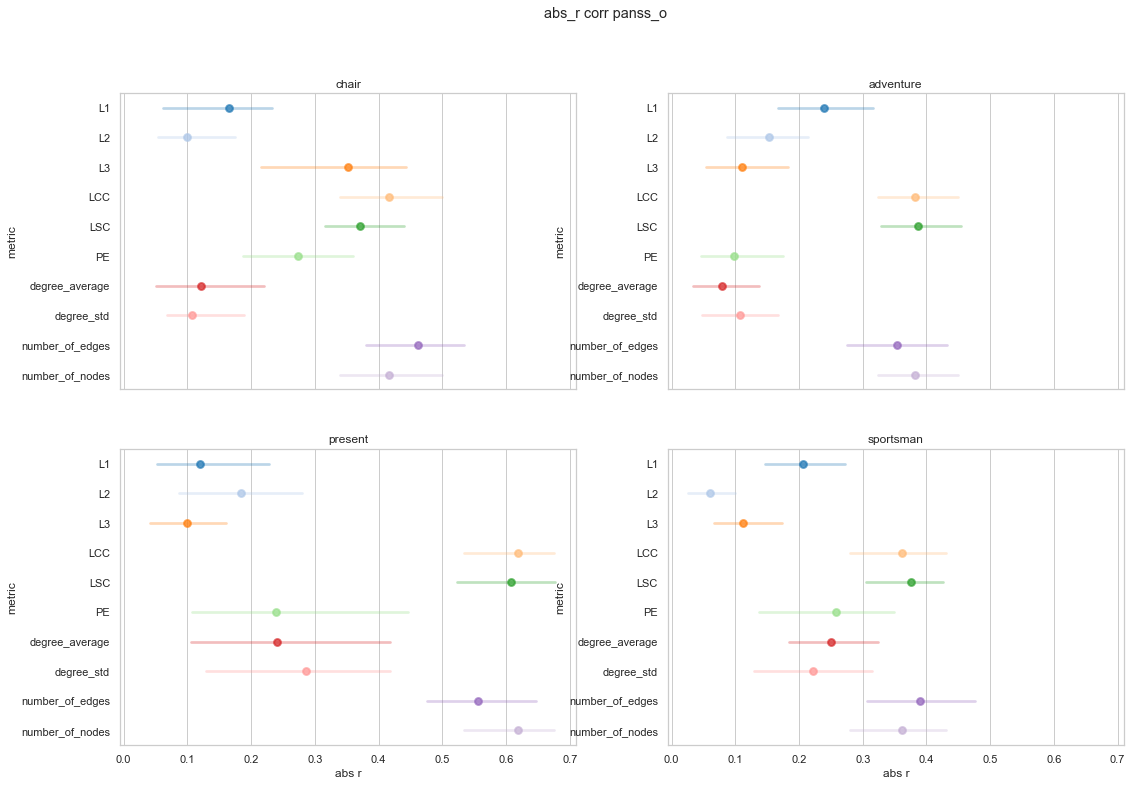

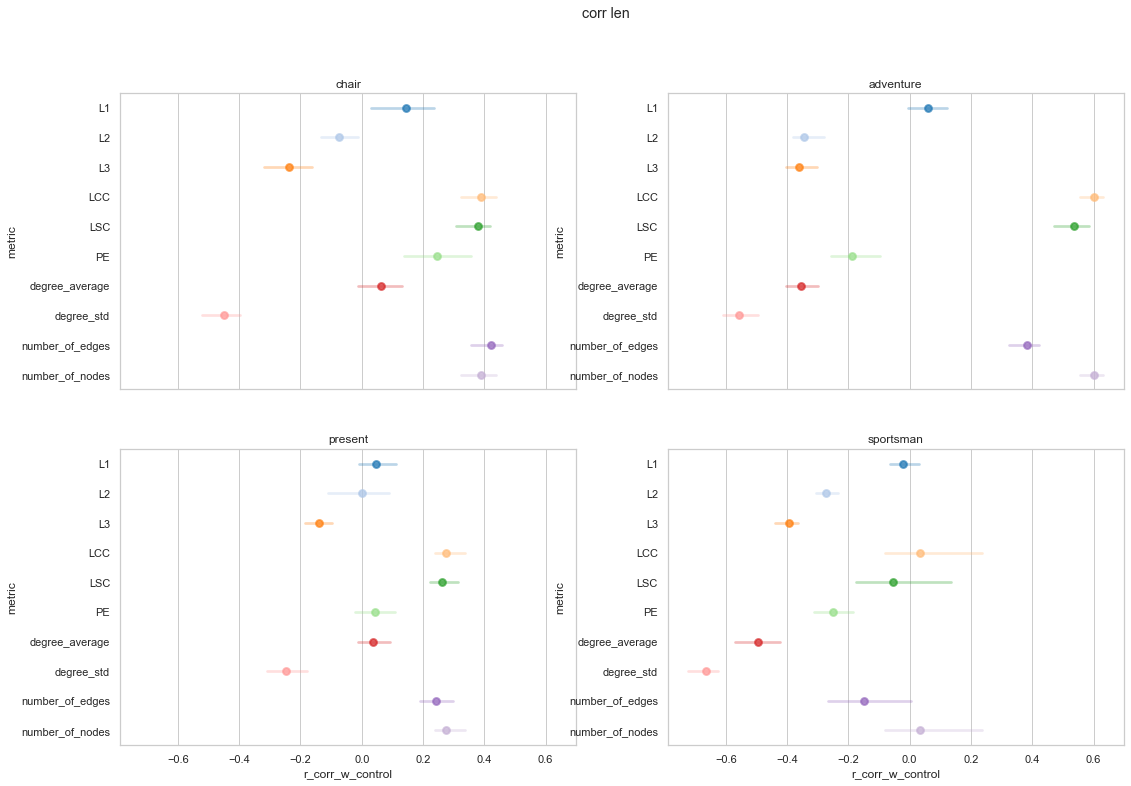

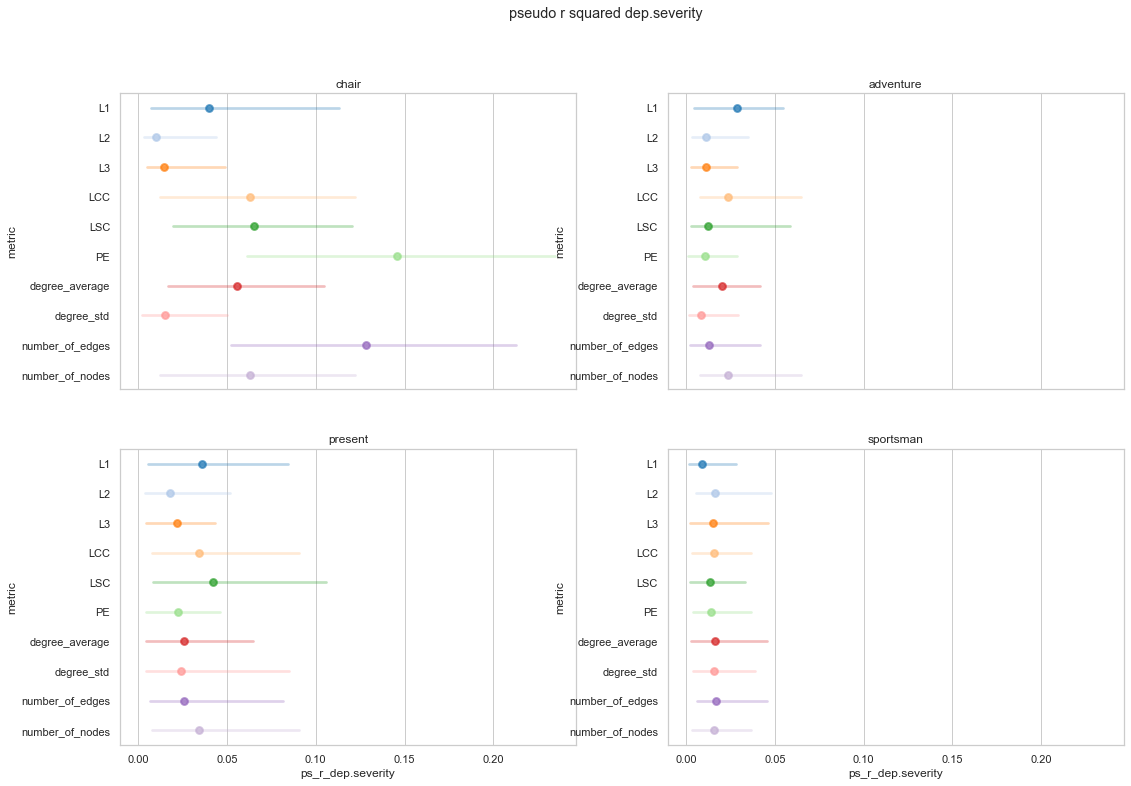

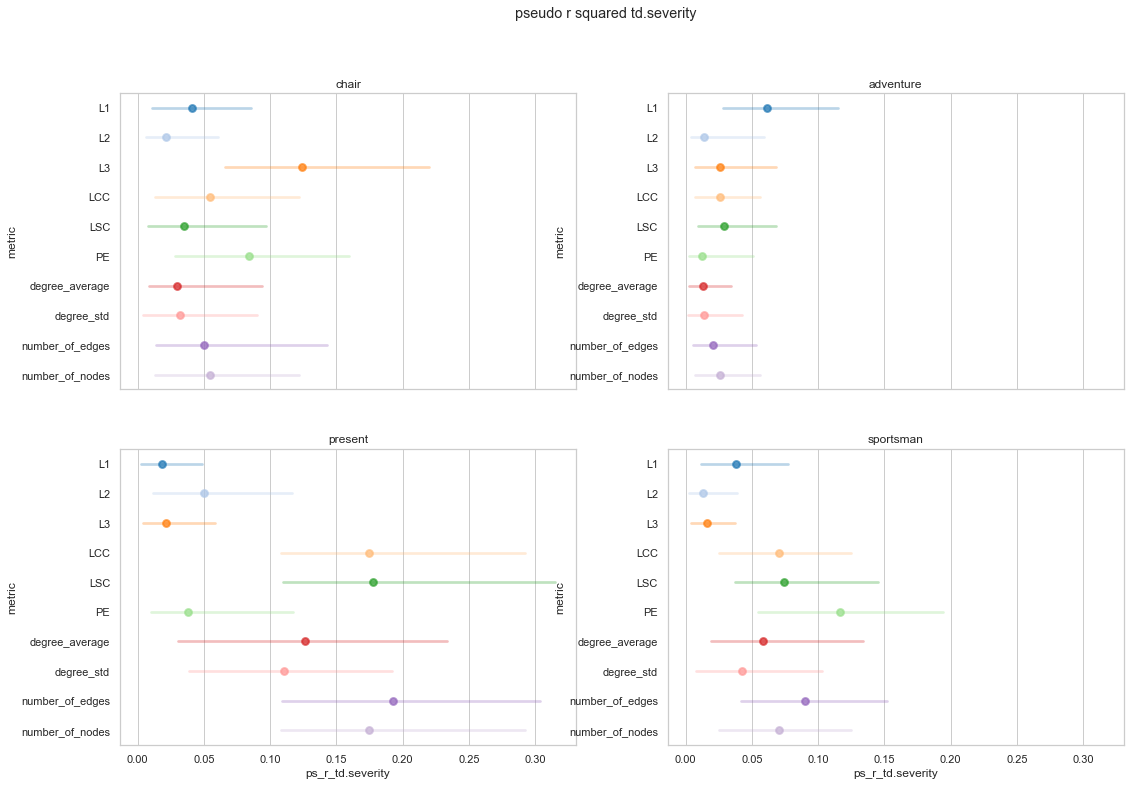

In [189]:
plot_all(reformed_d, 'graph', plot_abs=True)

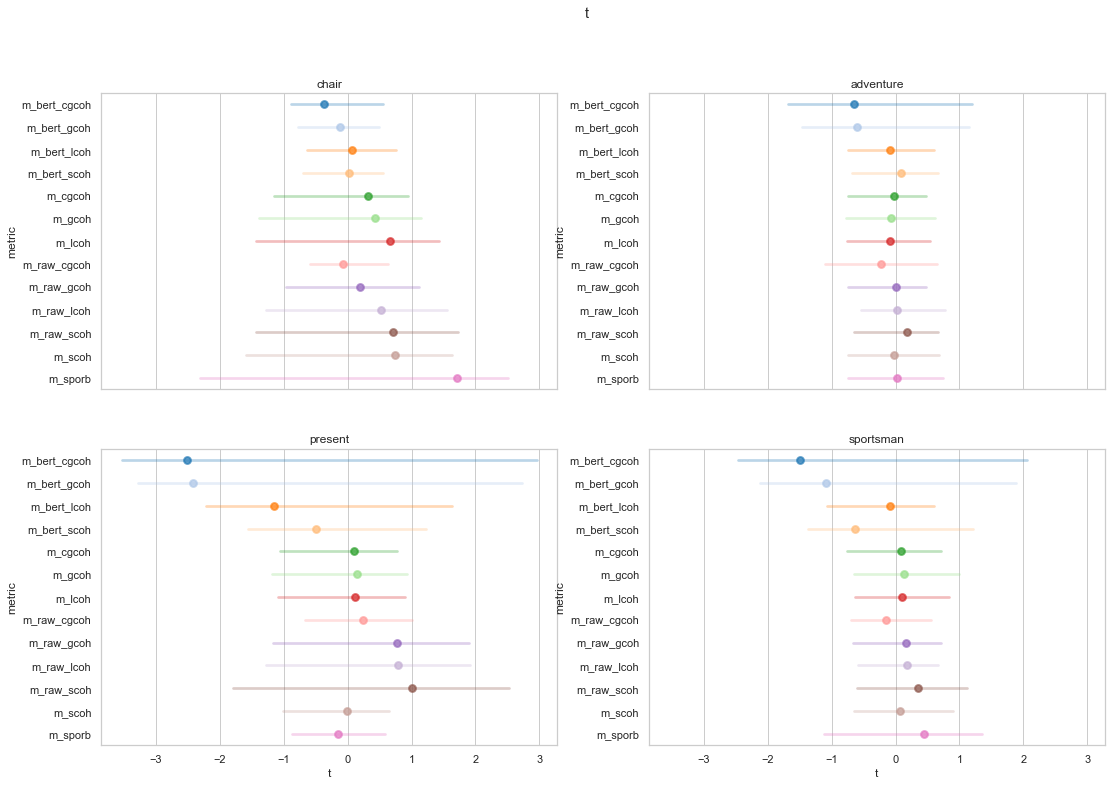

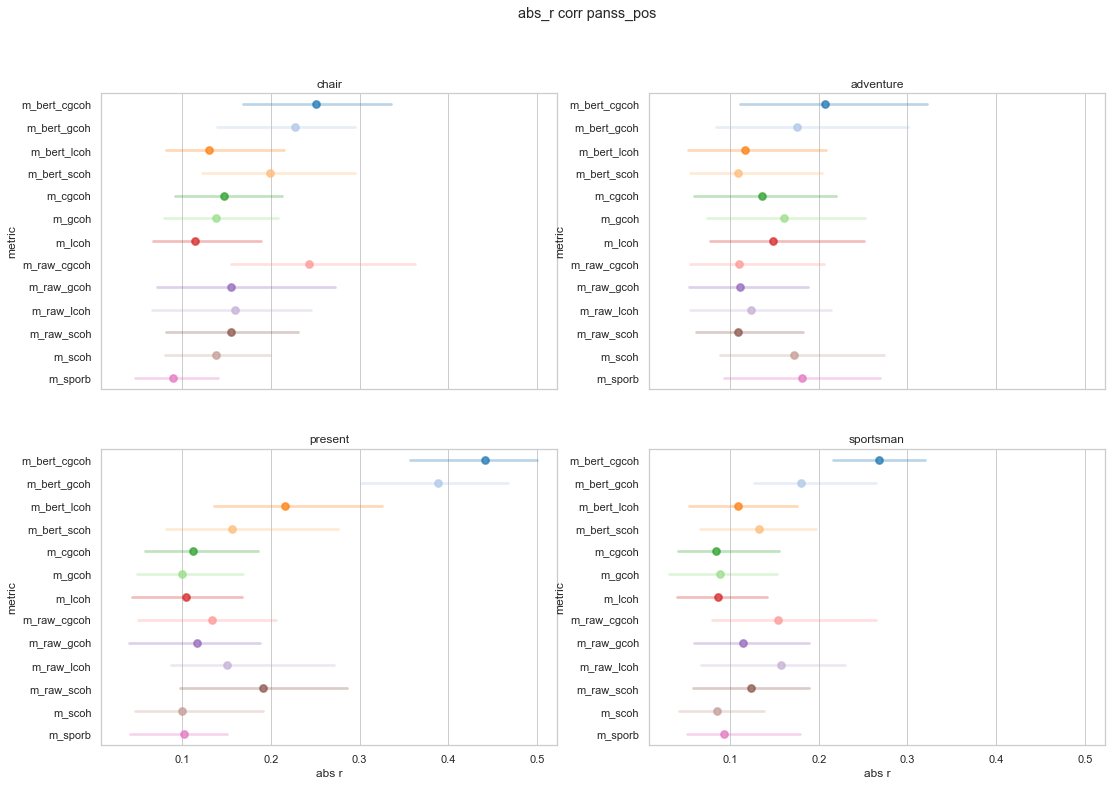

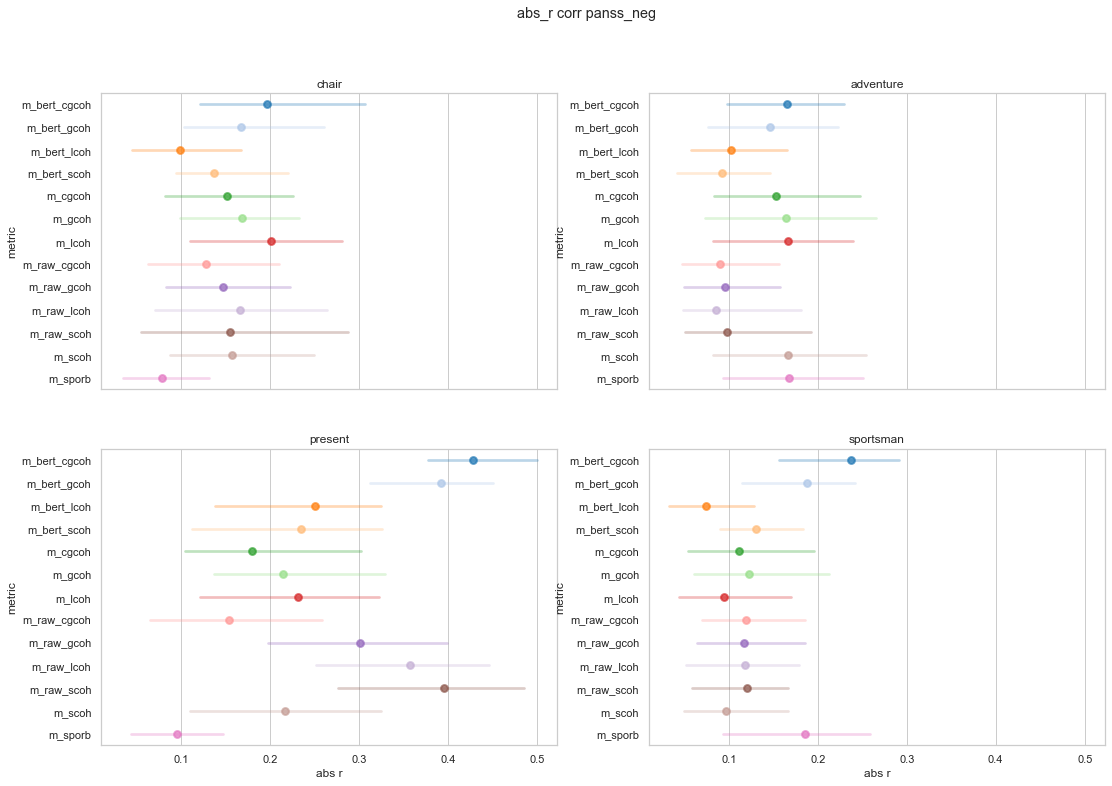

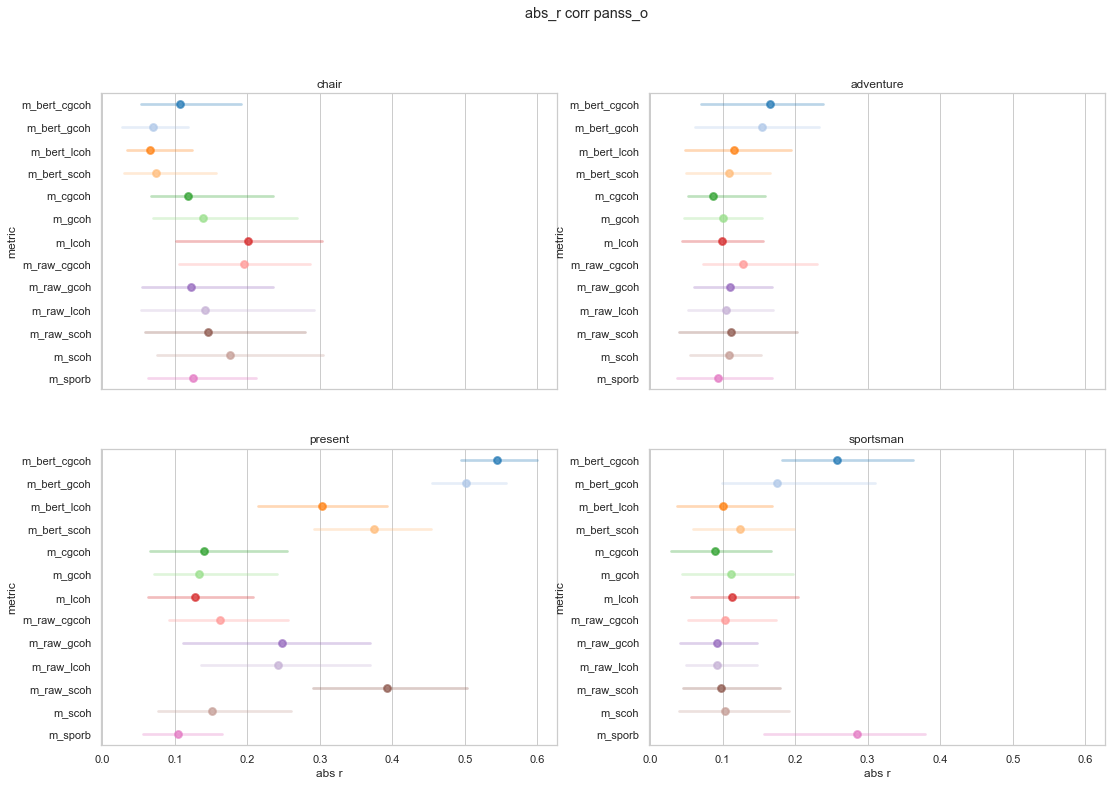

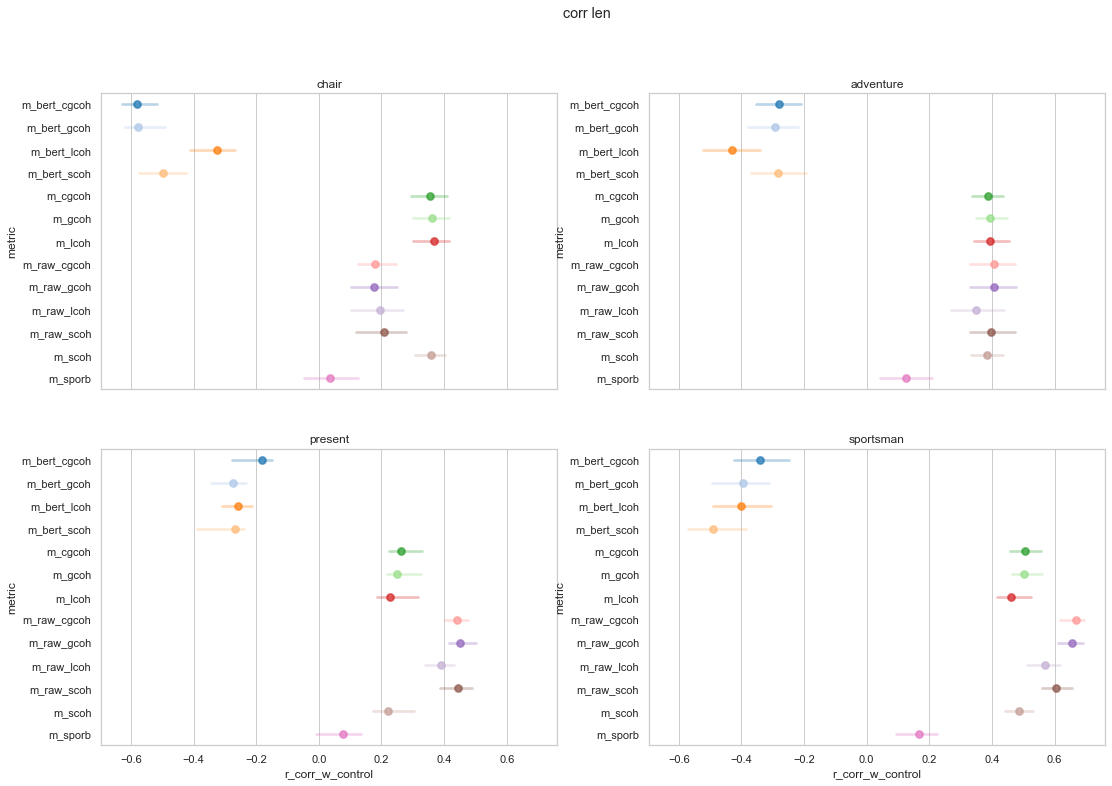

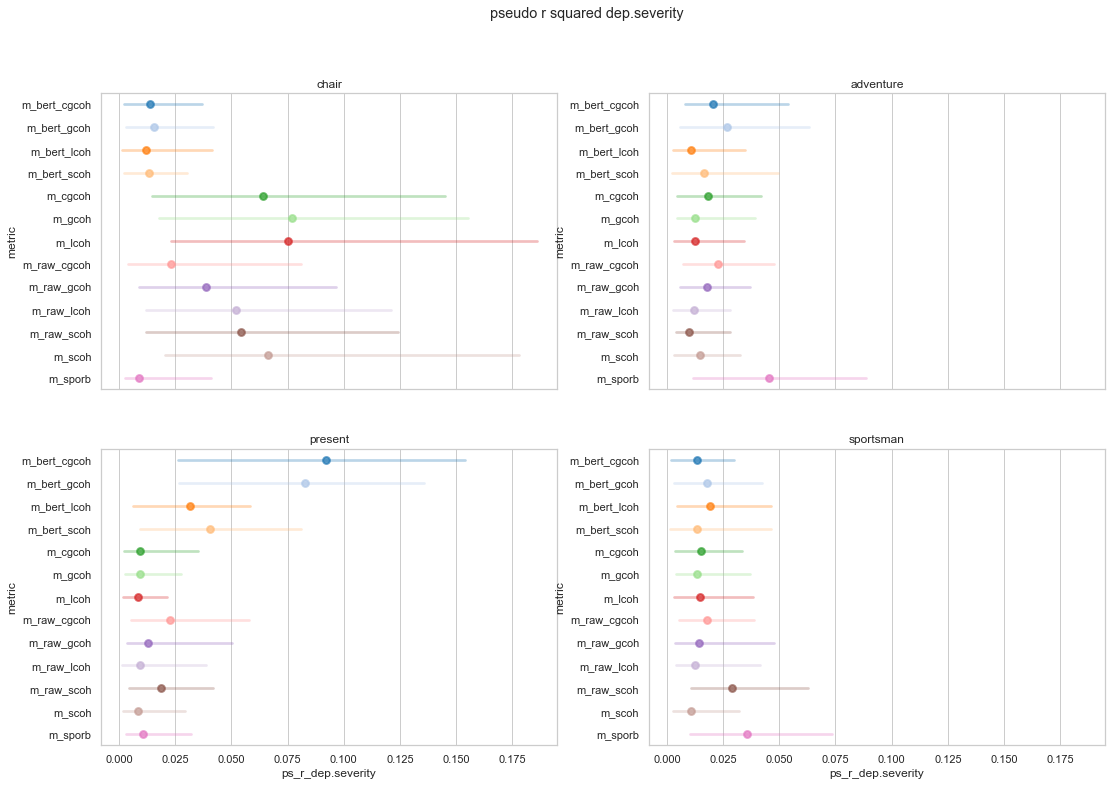

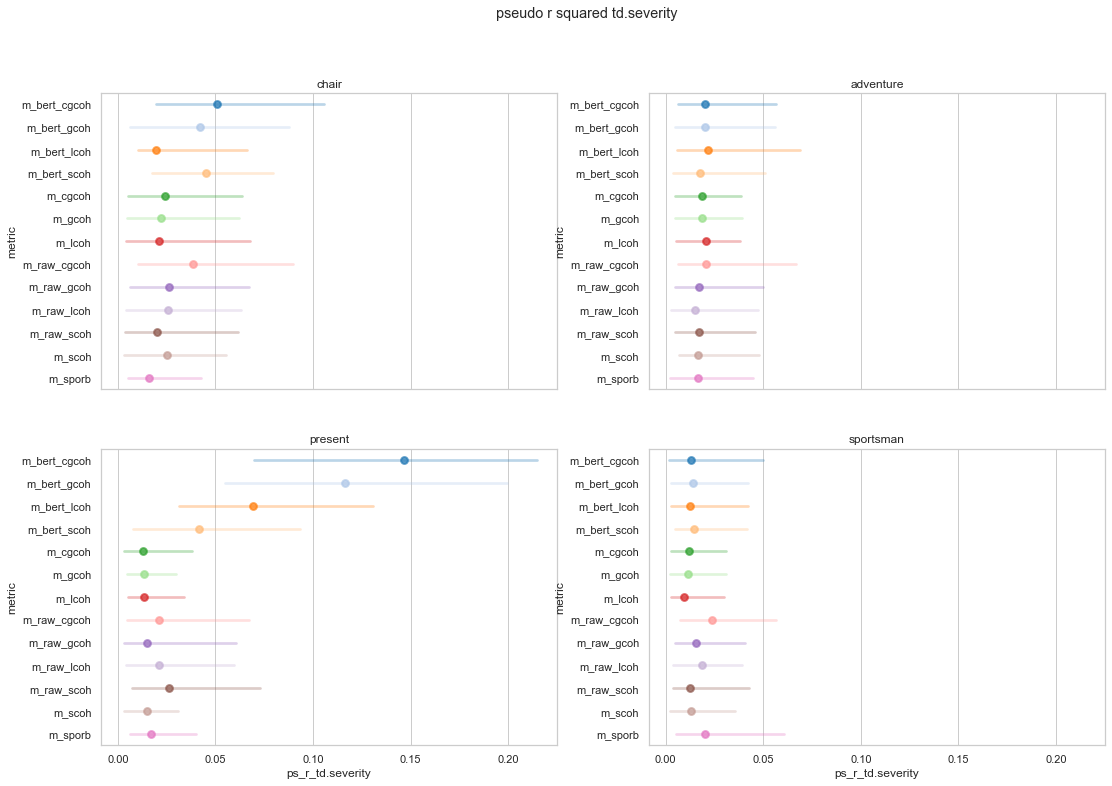

In [190]:
plot_all(reformed_d, 'LM', plot_abs=True)